## to-do:

- ~~exchange datasets~~
- ~~sort projects by size~~
- do statistics test, distribution (can assume normality?)
- normalize, e.g., fan-in, fan-out
- ~~public/private as percentage of everything~~
- rank projects by quality?
- use "very good" codes as a baseline
- inversely, use "very bad" codes
- types of project (e.g., UI-intensive vs. data-intensive)

In [1]:
import os

projects = os.listdir("metrics")
projects

['agrouml-v0.35.1',
 'checkstyle-v8.39',
 'freemind-v1.0.0',
 'ganttproject-v2.8.11',
 'GoGreen-v.0.1.3',
 'ipscan-v3.7.3',
 'jEdit-v5.5.0',
 'JetUML-v3.1',
 'jpass-v0.1.20',
 'keystore-explorer-v5.4.4',
 'LiveChatServer-v4.1',
 'LogFX-v0.9.1',
 'mars-sim-v3.1.0',
 'pgptool-v0.5.9.2',
 'sweethome3d-5.6']

In [2]:
import pandas as pd
import glob
import re

from rolestereotype import RoleStereotype as rs
rstr = [str(r) for r in rs]

datasets = dict()
for prj in projects:

  # role stereotype classification results
  files_rs = glob.glob(f"roleStereotypes/{prj}/*-features-classified.csv")
  df_rs = pd.read_csv(files_rs[0])

  # ck metrics output
  file_ck = f"metrics/{prj}/class.csv"
  df_ck = pd.read_csv(file_ck)

  # generate common identifier
  df_rs['classname2'] = [re.sub(r".*[\\/]|\.java$", '', n).replace(".", "$") for n in df_rs['Fullpathname']]
  df_ck['classname2'] = [re.sub(r".*\.", '', n) for n in df_ck['class']]

  # join the 2 dataframes
  df_rs.rename(columns={'loc': 'loc_1'}, inplace=True)
  df_merged = pd.merge(df_rs, df_ck, on= "classname2", how= "inner")
  datasets[prj] = df_merged

  line = f"{prj:24} ({df_merged.shape[0]:4} classes)"
  ct = df_merged['label'].value_counts(ascending=True, sort=False)
  print(f"{line} {',  '.join([f'{r}:{ct[r] if r in ct.keys() else 0:4}' for r in rstr])}")


agrouml-v0.35.1          (1290 classes) Controller:   2,  Coordinator:   3,  Information Holder: 216,  Interfacer: 102,  Service Provider: 962,  Structurer:   5
checkstyle-v8.39         (1056 classes) Controller:   0,  Coordinator:   1,  Information Holder: 413,  Interfacer:  18,  Service Provider: 618,  Structurer:   6
freemind-v1.0.0          ( 371 classes) Controller:   9,  Coordinator:   0,  Information Holder:  66,  Interfacer:  35,  Service Provider: 254,  Structurer:   7
ganttproject-v2.8.11     ( 685 classes) Controller:   1,  Coordinator:   3,  Information Holder: 146,  Interfacer:  58,  Service Provider: 465,  Structurer:  12
GoGreen-v.0.1.3          (  66 classes) Controller:   2,  Coordinator:   1,  Information Holder:  18,  Interfacer:   0,  Service Provider:  45,  Structurer:   0
ipscan-v3.7.3            ( 159 classes) Controller:   0,  Coordinator:   0,  Information Holder:  27,  Interfacer:  13,  Service Provider: 118,  Structurer:   1
jEdit-v5.5.0             ( 583 cla

In [3]:
# all class metrics: cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,lcom*,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,visibleMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,totalFieldsQty,staticFieldsQty,publicFieldsQty,privateFieldsQty,protectedFieldsQty,defaultFieldsQty,finalFieldsQty,synchronizedFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
metrics = "cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom*,tcc,lcc,totalMethodsQty,publicMethodsQty,privateMethodsQty,abstractMethodsQty,finalMethodsQty,totalFieldsQty,publicFieldsQty,privateFieldsQty,finalFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,ratio_publicMethods,ratio_privateMethods,ratio_publicFields,ratio_privateFields".split(',')
len(metrics)

41

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [5]:
alldf = pd.DataFrame()
for prj,df in datasets.items():
  df['project'] = [prj] * df.shape[0]
  alldf = alldf.append(df)

# throw away invalid values
alldf['tcc'] = [np.nan if n==-1 else n for n in alldf['tcc']]
alldf['lcc'] = [np.nan if n==-1 else n for n in alldf['lcc']]

# add ratios
alldf['ratio_publicMethods'] = alldf['publicMethodsQty']/alldf['totalMethodsQty']
alldf['ratio_privateMethods'] = alldf['privateMethodsQty']/alldf['totalMethodsQty']
alldf['ratio_publicFields'] = alldf['publicFieldsQty']/alldf['totalFieldsQty']
alldf['ratio_privateFields'] = alldf['privateFieldsQty']/alldf['totalFieldsQty']

# alldf.to_csv("all.csv")
  


In [6]:
metrics_def = {
  'cbo': "CBO (Coupling between objects): Counts the number of dependencies a class has. The tools checks for any type used in the entire class (field declaration, method return types, variable declarations, etc). It ignores dependencies to Java itself (e.g. java.lang.String).",
  'cboModified': "CBO Modified (Coupling between objects): Counts the number of dependencies a class has. It is very similar to the CKTool's original CBO. However, this metric considers a dependency from a class as being both the references the type makes to others and the references that it receives from other types.",
  'fanin': "FAN-IN: Counts the number of input dependencies a class has, i.e, the number of classes that reference a particular class. For instance, given a class X, the fan-in of X would be the number of classes that call X by referencing it as an attribute, accessing some of its attributes, invoking some of its methods, etc.",
  'fanout': "FAN-OUT: Counts the number of output dependencies a class has, i.e, the number of other classes referenced by a particular class. In other words, given a class X, the fan-out of X is the number of classes called by X via attributes reference, method invocations, object instances, etc.",
  'dit': "DIT (Depth Inheritance Tree): It counts the number of \"fathers\" a class has. All classes have DIT at least 1 (everyone inherits java.lang.Object). In order to make it happen, classes must exist in the project (i.e. if a class depends upon X which relies in a jar/dependency file, and X depends upon other classes, DIT is counted as 2).",
  'noc': "NOC (Number of Children): It counts the number of immediate subclasses that a particular class has.",
  'FieldsQty': "Number of fields: Counts the number of fields. Specific numbers for total number of fields, static, public, private, protected, default, final, and synchronized fields.",
  'MethodsQty': "Number of methods: Counts the number of methods. Specific numbers for total number of methods, static, public, abstract, private, protected, default, final, and synchronized methods. Constructor methods also count here.",
  'visibleMethodsQty': "Number of visible methods: Counts the number of visible methods. A method is visible if it is not private.",
  'nosi': "NOSI (Number of static invocations): Counts the number of invocations to static methods. It can only count the ones that can be resolved by the JDT.",
  'rfc': "RFC (Response for a Class): Counts the number of unique method invocations in a class. As invocations are resolved via static analysis, this implementation fails when a method has overloads with same number of parameters, but different types.",
  'wmc': "WMC (Weight Method Class) or McCabe's complexity. It counts the number of branch instructions in a class.",
  'loc': "LOC (Lines of code): It counts the lines of count, ignoring empty lines and comments (i.e., it's Source Lines of Code, or SLOC). The number of lines here might be a bit different from the original file, as we use JDT's internal representation of the source code to calculate it.",
  'lcom': "LCOM (Lack of Cohesion of Methods): Calculates LCOM metric. This is the very first version of metric, which is not reliable. LCOM-HS can be better (hopefully, you will send us a pull request).",
  'lcom*': "LCOM* (Lack of Cohesion of Methods): This metric is a modified version of the current version of LCOM implemented in CK Tool. LCOM* is a normalized metric that computes the lack of cohesion of class within a range of 0 to 1. Then, the closer to 1 the value of LCOM* in a class, the less the cohesion degree of this respective class. The closer to 0 the value of LCOM* in a class, the most the cohesion of this respective class. This implementation follows the third version of LCOM* defined in [1]. Reference: [1] Henderson-Sellers, Brian, Larry L. Constantine and Ian M. Graham. “Coupling and cohesion (towards a valid metrics suite for object-oriented analysis and design).” Object Oriented Systems 3 (1996): 143-158.",
  'tcc': "TCC (Tight Class Cohesion): Measures the cohesion of a class with a value range from 0 to 1. TCC measures the cohesion of a class via direct connections between visible methods, two methods or their invocation trees access the same class variable.",
  'lcc': "LCC (Loose Class Cohesion): Similar to TCC but it further includes the number of indirect connections between visible classes for the cohesion calculation. Thus, the constraint LCC >= TCC holds always.",
  'returnQty': "Quantity of returns: The number of return instructions.",
  'loopQty': "Quantity of loops: The number of loops (i.e., for, while, do while, enhanced for).",
  'comparisonsQty': "Quantity of comparisons: The number of comparisons (i.e., == and !=). Note: != is only available in 0.4.2+.",
  'tryCatchQty': "Quantity of try/catches: The number of try/catches",
  'parenthesizedExpsQty': "Quantity of parenthesized expressions: The number of expressions inside parenthesis.",
  'stringLiteralsQty': "String literals: The number of string literals (e.g., \"John Doe\"). Repeated strings count as many times as they appear.",
  'numbersQty': "Quantity of Number: The number of numbers (i.e., int, long, double, float) literals.",
  'mathOperationsQty': "Quantity of Math Operations: The number of math operations (times, divide, remainder, plus, minus, left shit, right shift).",
  'variablesQty': "Quantity of Variables: Number of declared variables.",
  'maxNestedBlocksQty': "Max nested blocks: The highest number of blocks nested together.",
  'anonymousClassesQty': "Quantity of Anonymous classes, inner classes, and lambda expressions: The name says it all. Note that whenever an anonymous class or an inner class is declared, it becomes an \"entire new class\", e.g., CK generates A.B and A.B$C, C being an inner class inside A.B. However, lambda expressions are not considered classes, and thus, are part of the class/method they are embedded into. A class or a method only has the number of inner classes that are declared at its level, e.g., an inner class that is declared inside a method M2, that is inside an anonymous class A, that is declared inside a method M, that finally is declared inside a class C, will not count in class C, but only in method M2 (first-level method it is embodied), and anonymous class A (first-level class it is embodied).",
  'uniqueWordsQty': "Number of unique words: Number of unique words in the source code. At method level, it only uses the method body as input. At class level, it uses the entire body of the class as metrics. The algorithm basically counts the number of words in a method/class, after removing Java keywords. Names are split based on camel case and underline (e.g., longName_likeThis becomes four words). See WordCounter class for details on the implementation.",
  'logStatementsQty': "Number of Log Statements: Number of log statements in the source code. The counting uses REGEX compatible with SLF4J and Log4J API calls. See NumberOfLogStatements.java and the test examples (NumberOfLogStatementsTest and fixtures/logs) for more info.",

# Has Javadoc: Boolean indicating whether a method has javadoc. (Only at method-level for now)
  'modifiers': "modifiers: public/abstract/private/protected/native modifiers of classes/methods. Can be decoded using org.eclipse.jdt.core.dom.Modifier.",

# Usage of each variable: How often each variable was used inside each method.

# Usage of each field: How often each local field was used inside each method, local field are fields within a class (subclasses are not included). Also indirect local field usages are detected, indirect local field usages include all usages of fields within the local invocation tree of a class e.g. A invokes B and B uses field a, then a is indirectly used by A.

# Method invocations: All directly invoked methods, variations are local invocations and indirect local invocations.
}

In [7]:
prj_order = list(alldf.groupby(['project']).sum()['loc'].sort_values(ascending=False).keys())
prj_order

['mars-sim-v3.1.0',
 'sweethome3d-5.6',
 'agrouml-v0.35.1',
 'jEdit-v5.5.0',
 'ganttproject-v2.8.11',
 'keystore-explorer-v5.4.4',
 'checkstyle-v8.39',
 'freemind-v1.0.0',
 'pgptool-v0.5.9.2',
 'JetUML-v3.1',
 'ipscan-v3.7.3',
 'LogFX-v0.9.1',
 'jpass-v0.1.20',
 'LiveChatServer-v4.1',
 'GoGreen-v.0.1.3']

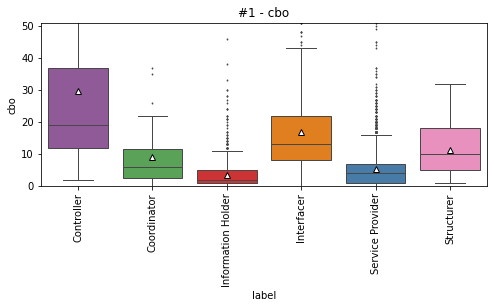

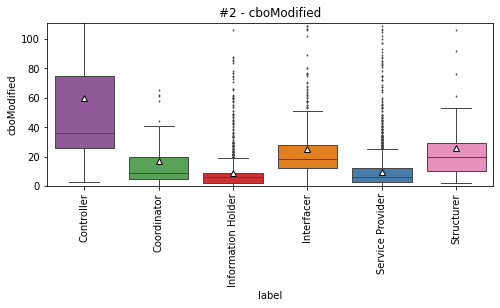

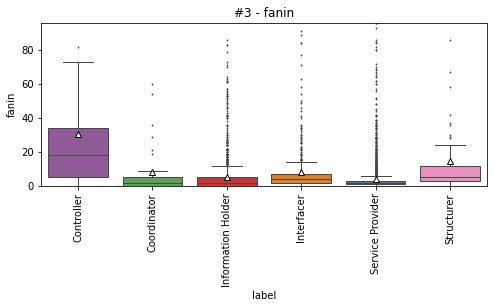

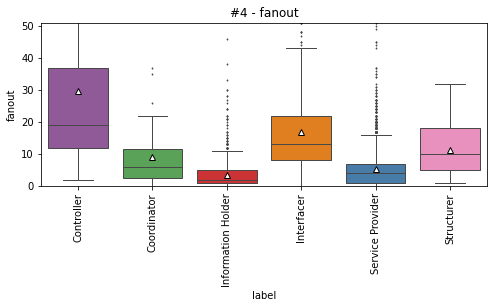

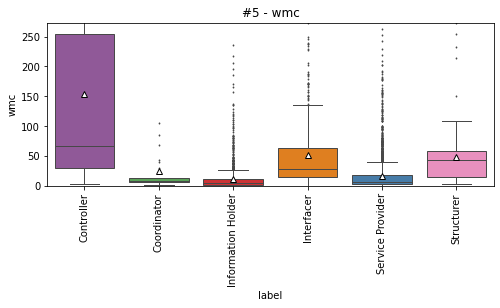

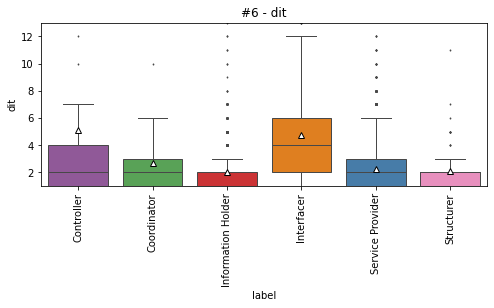

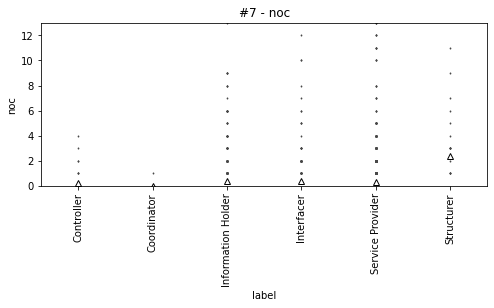

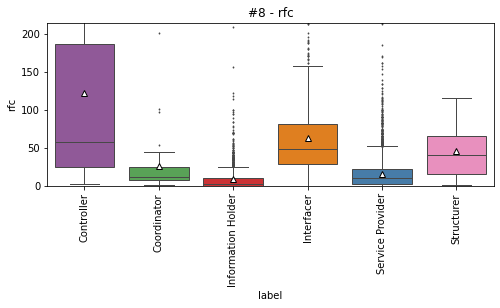

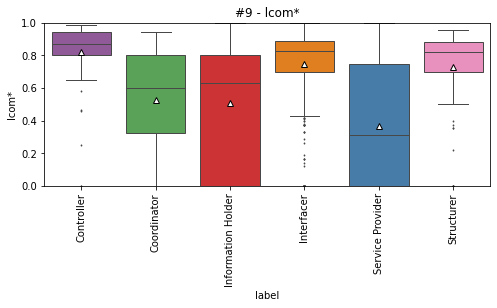

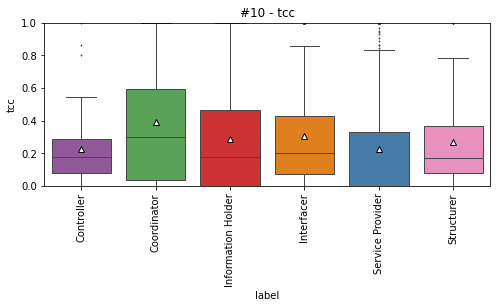

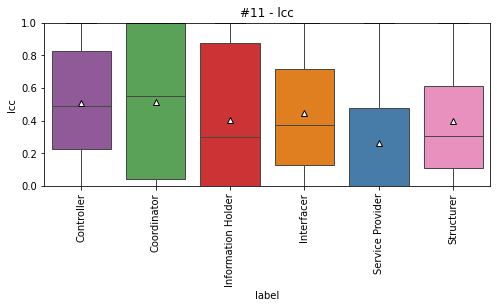

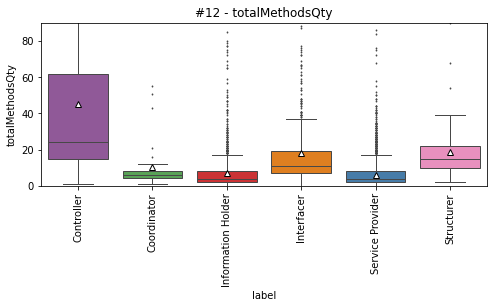

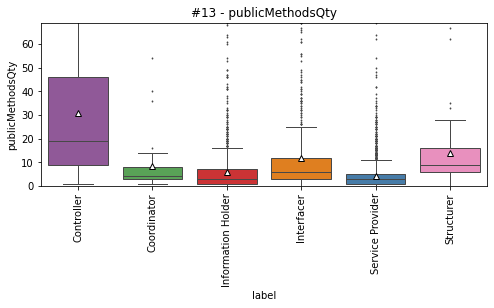

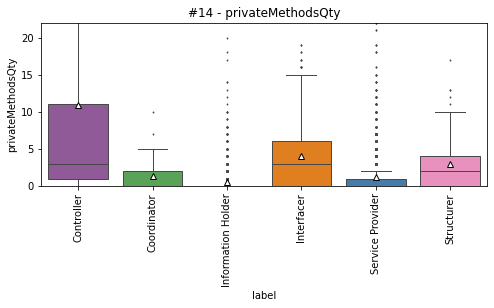

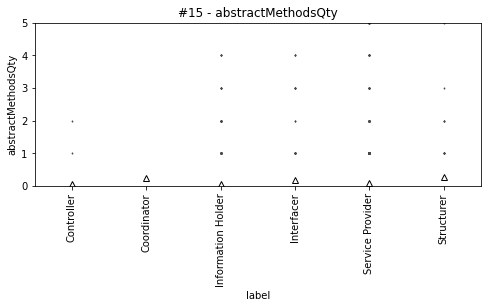

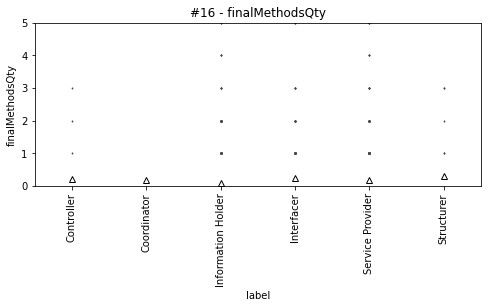

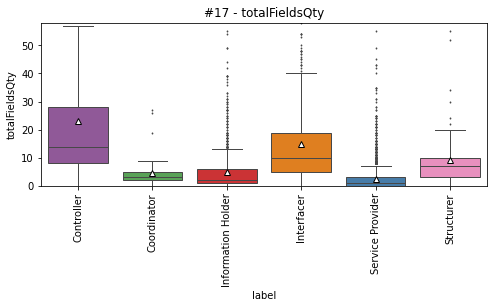

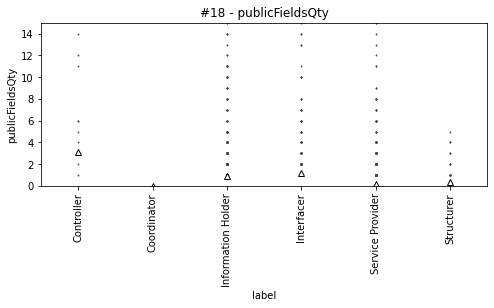

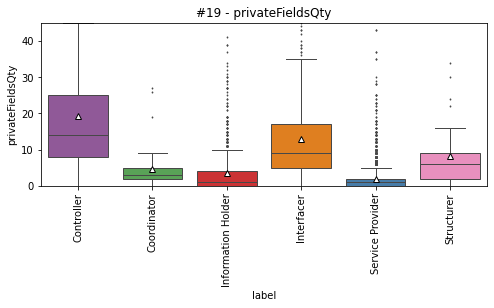

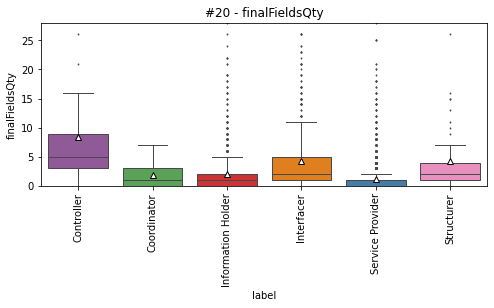

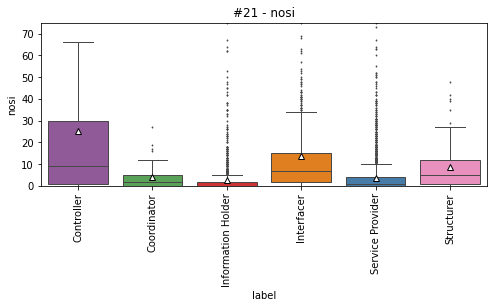

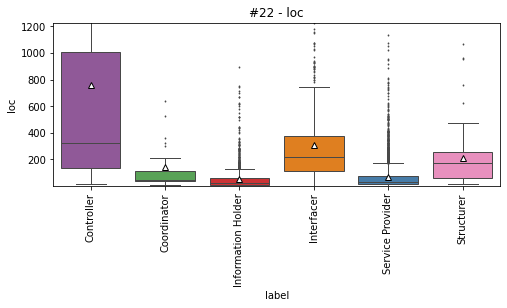

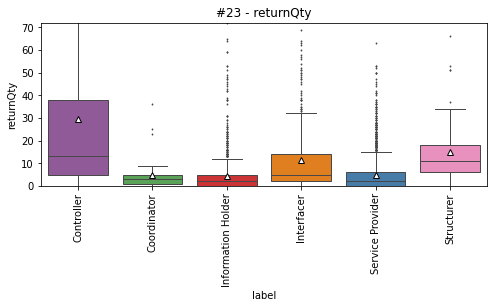

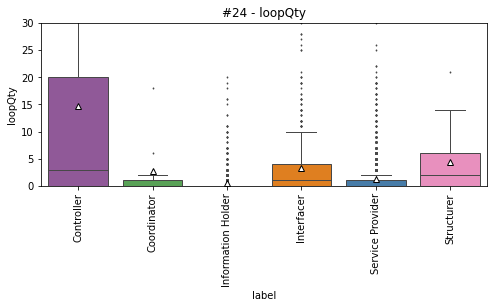

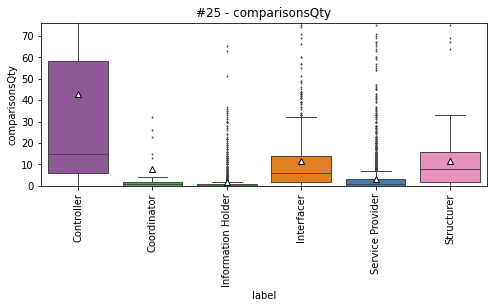

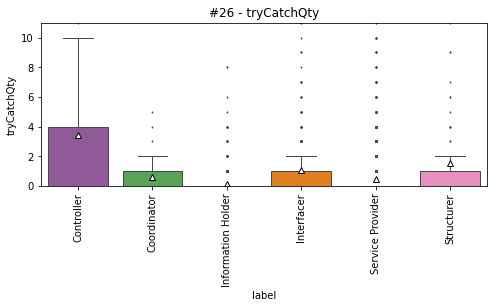

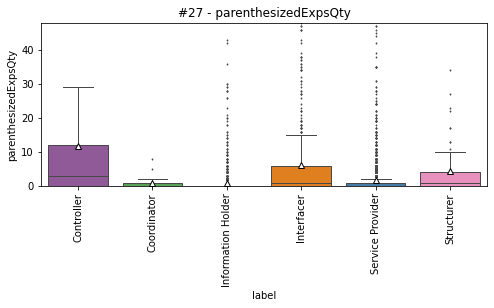

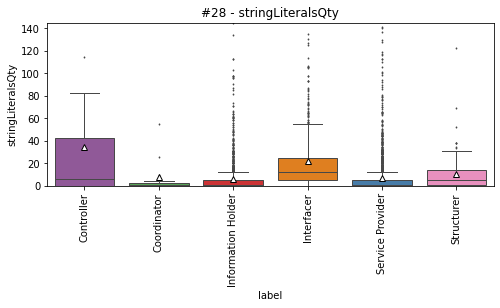

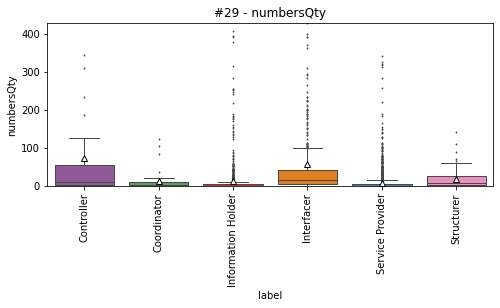

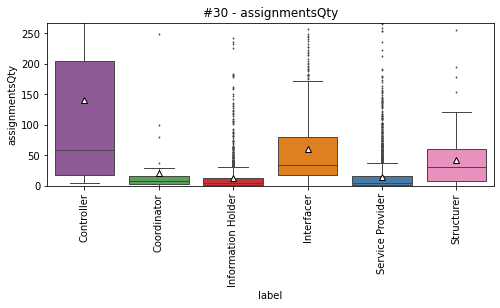

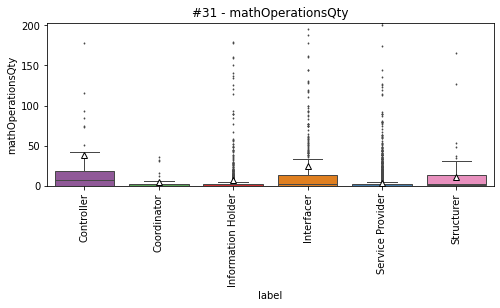

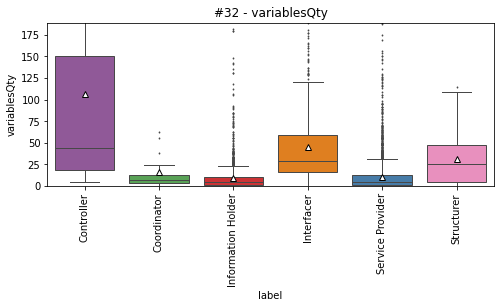

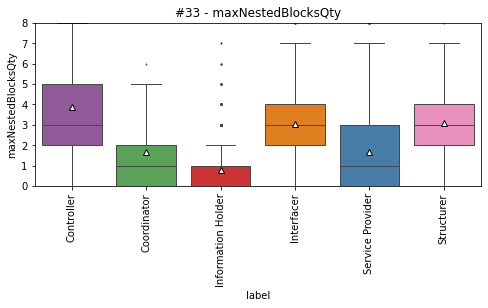

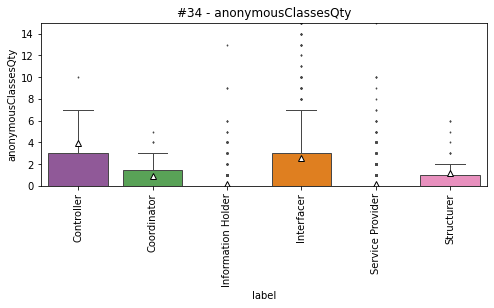

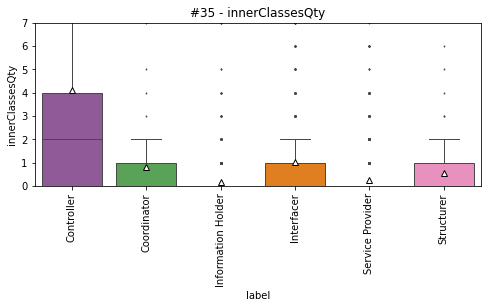

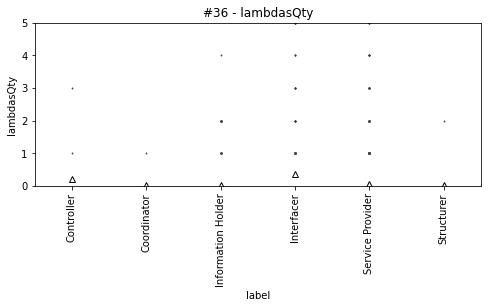

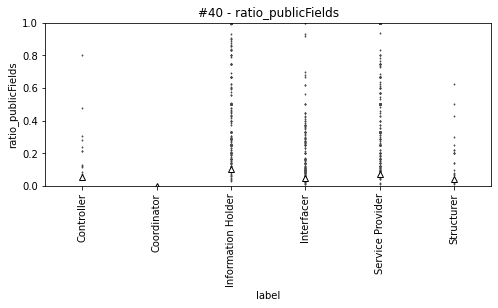

In [8]:
i = 0
for m in metrics:
    plt.figure(i, figsize=(8,3))

    g = sns.boxplot(x='label', y=m,
        palette=rs.dpalette(),
        order=rstr,
        linewidth=1, fliersize=1,
        showmeans=True,
        meanprops = {"markerfacecolor":"white", "markeredgecolor": "black"},
        data=alldf,)
    mn = alldf[m].min() 
    mx = alldf.quantile(.995, interpolation="higher")[m]
    g.set(ylim=(mn,mx), title=f'#{i+1} - {m}')

    plt.xticks(rotation = 90)
    plt.show()
    i += 1

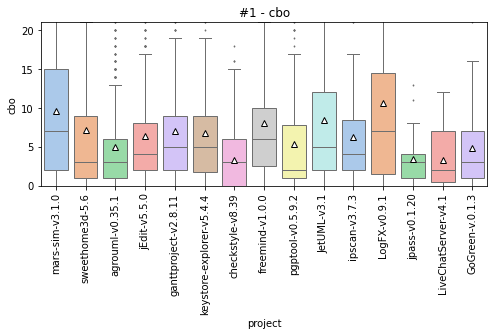

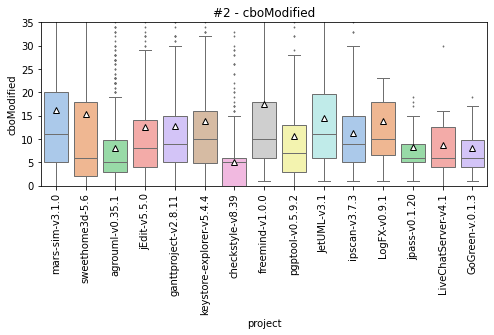

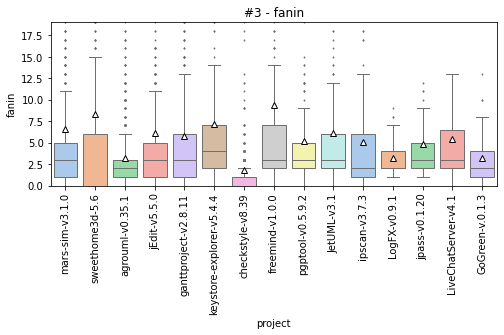

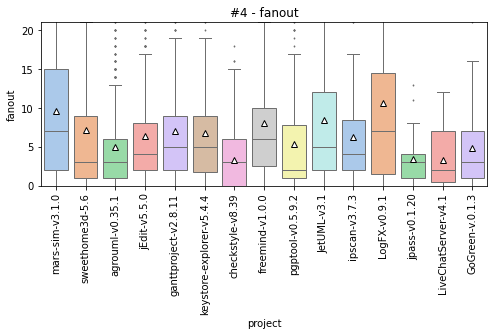

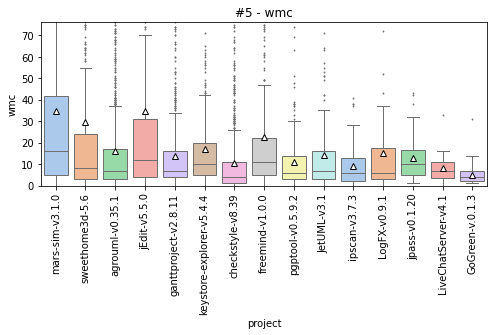

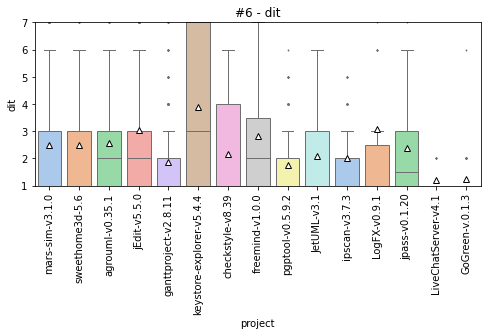

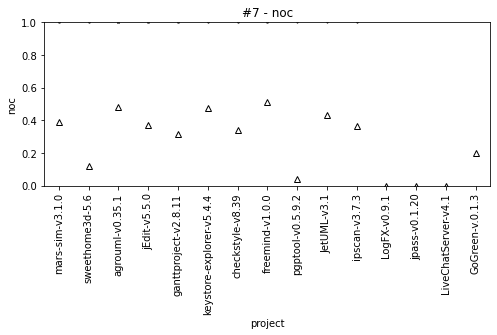

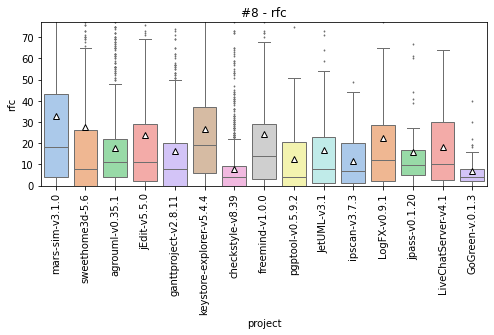

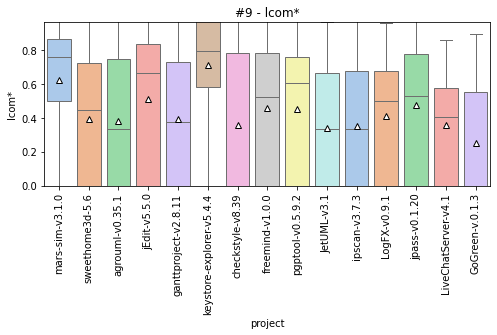

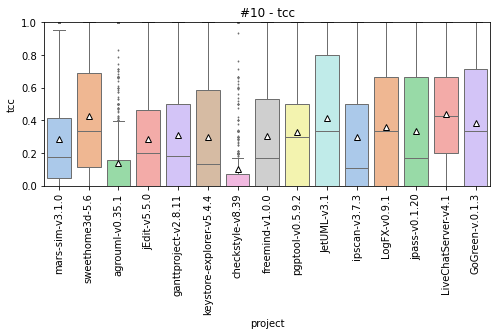

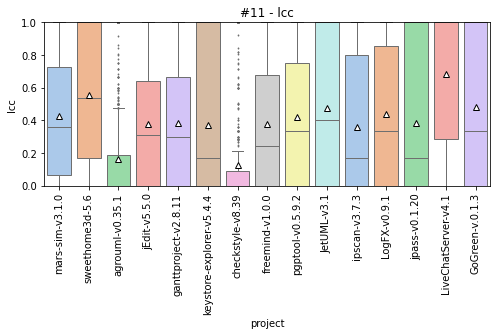

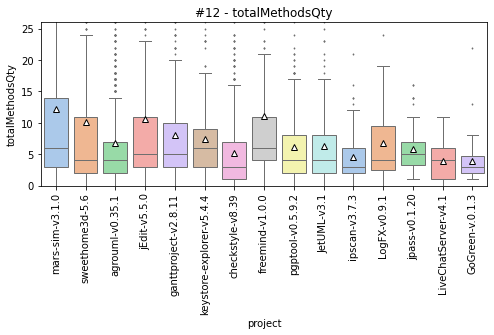

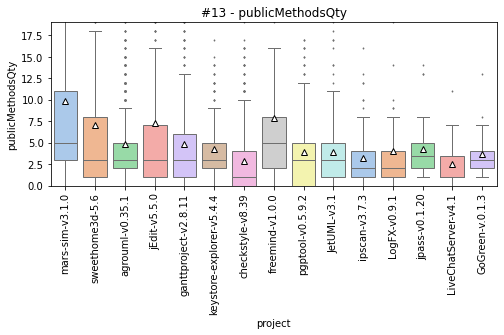

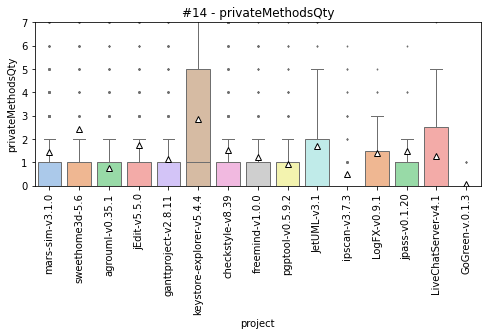

C:\Users\20215365\AppData\Local\Temp\ipykernel_9136\889515410.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  g.set(ylim=(mn,mx), title=f'#{i+1} - {m}')


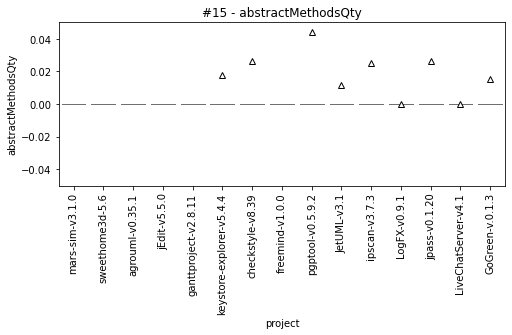

C:\Users\20215365\AppData\Local\Temp\ipykernel_9136\889515410.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  g.set(ylim=(mn,mx), title=f'#{i+1} - {m}')


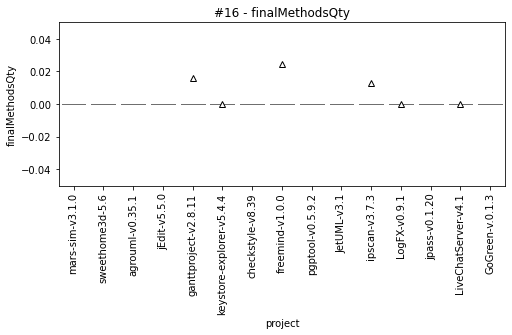

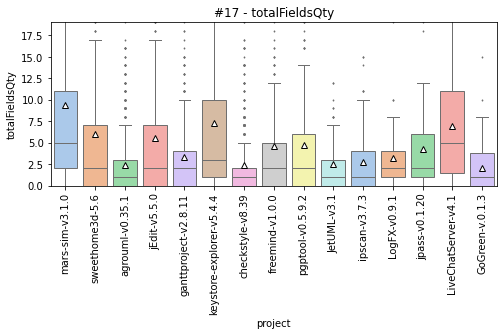

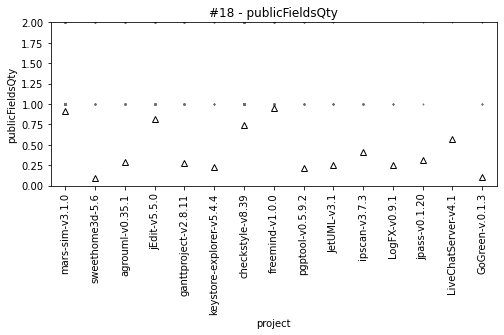

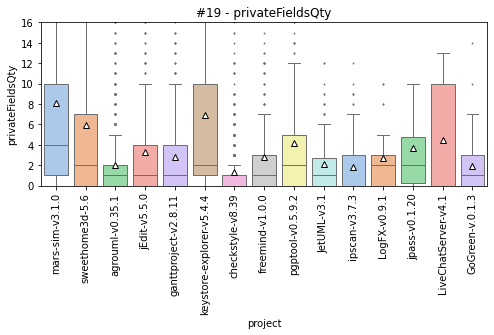

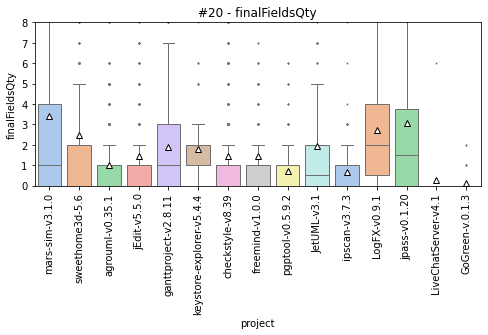

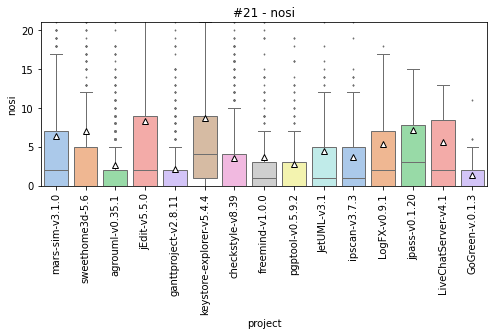

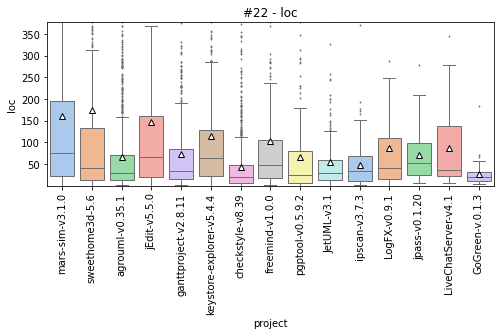

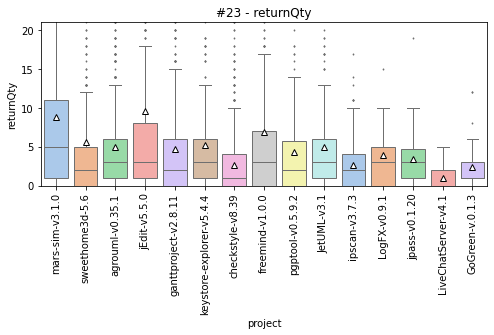

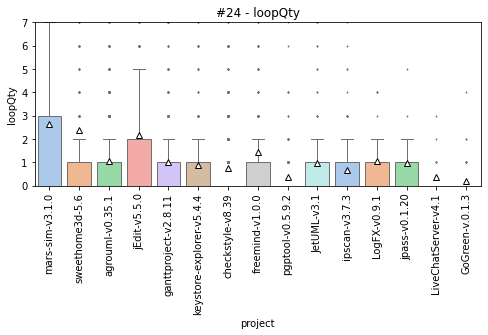

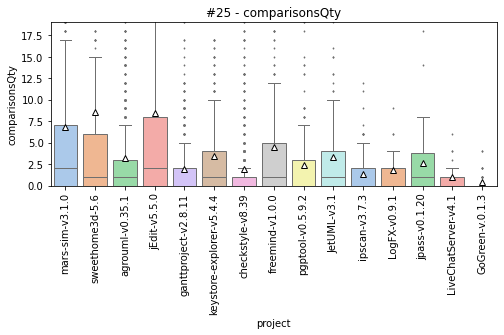

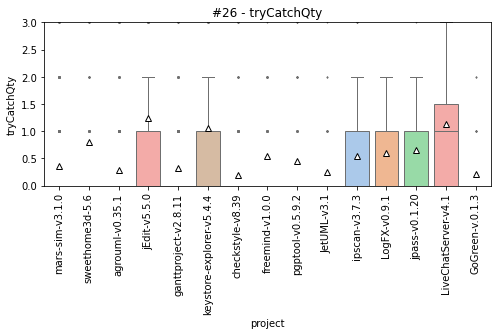

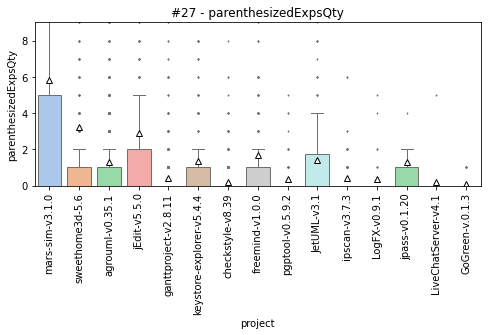

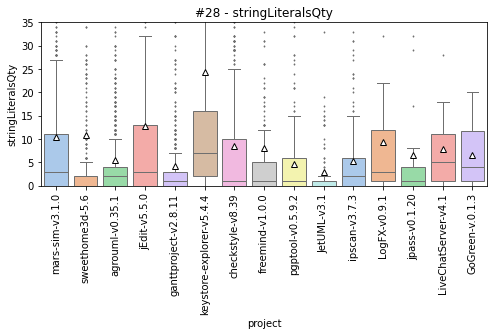

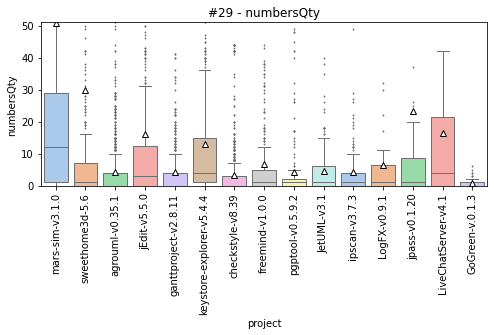

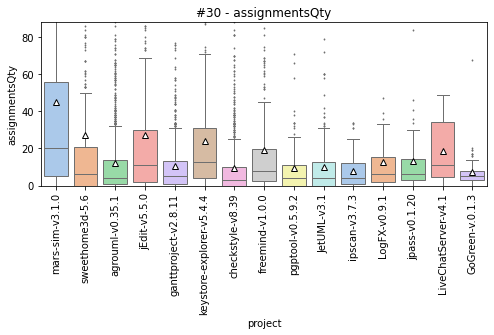

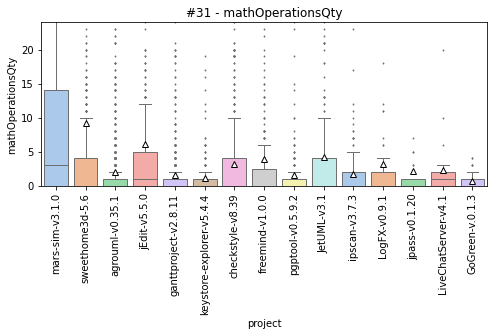

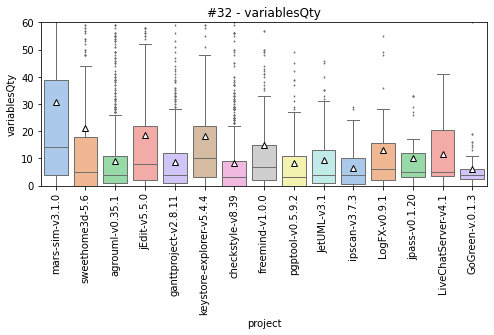

C:\Users\20215365\AppData\Local\Temp\ipykernel_9136\889515410.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  g.set(ylim=(mn,mx), title=f'#{i+1} - {m}')


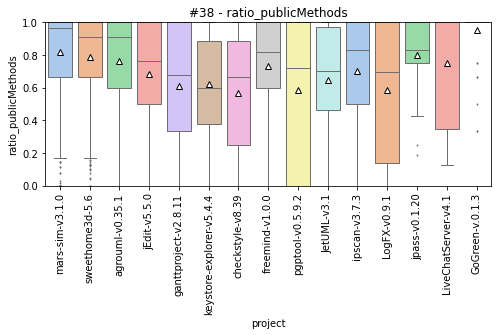

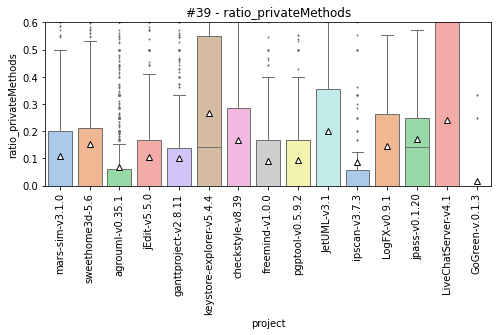

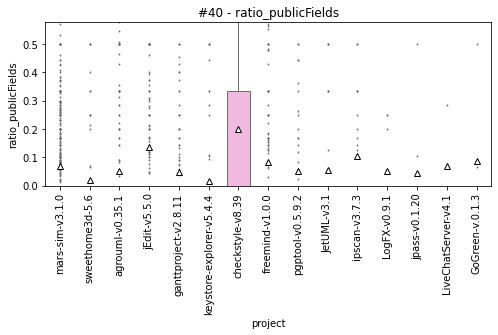

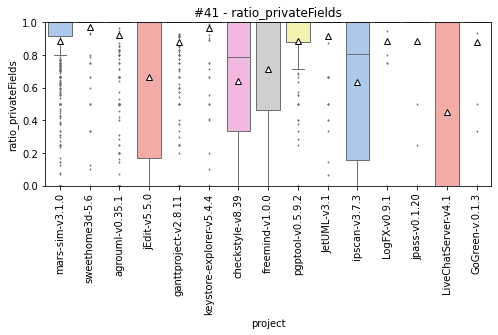

In [9]:
i = 0
for m in metrics:
    plt.figure(i, figsize=(8,3))

    g = sns.boxplot(x='project', y=m,
        palette="pastel",
        order=prj_order,
        linewidth=1, fliersize=1,
        showmeans=True,
        meanprops = {"markerfacecolor":"white", "markeredgecolor": "black"},
        data=alldf,)
    mn = alldf[m].min() 
    mx = alldf.quantile(.95, interpolation="higher")[m]
    g.set(ylim=(mn,mx), title=f'#{i+1} - {m}')

    plt.xticks(rotation = 90)
    plt.show()
    i += 1

[cbo]
CBO (Coupling between objects): Counts the number of dependencies a class has. The tools checks for any type used in the entire class (field declaration, method return types, variable declarations, etc). It ignores dependencies to Java itself (e.g. java.lang.String).


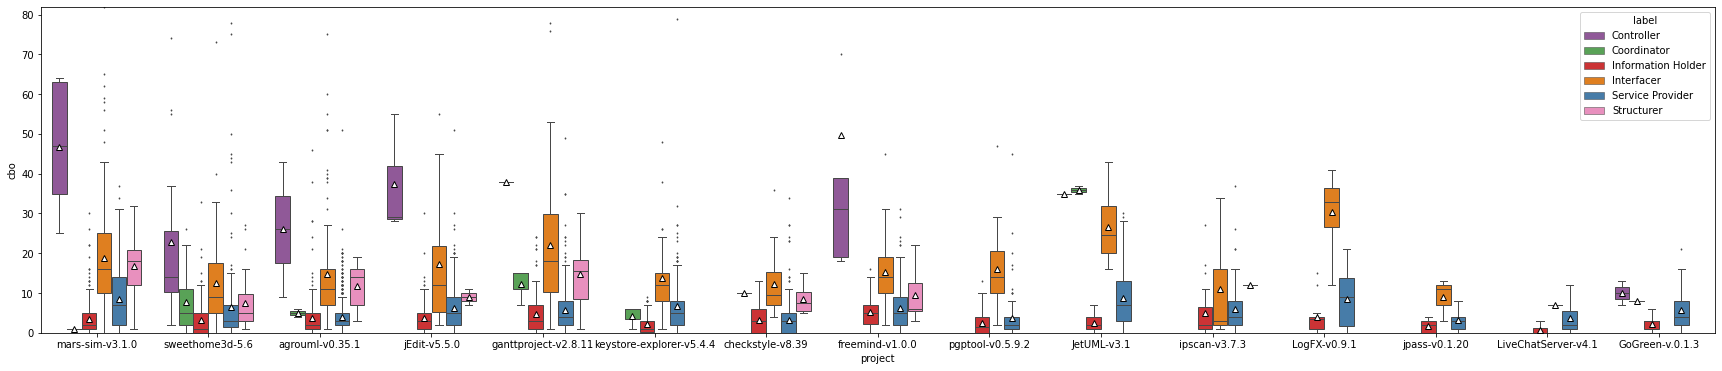

[cboModified]
CBO Modified (Coupling between objects): Counts the number of dependencies a class has. It is very similar to the CKTool's original CBO. However, this metric considers a dependency from a class as being both the references the type makes to others and the references that it receives from other types.


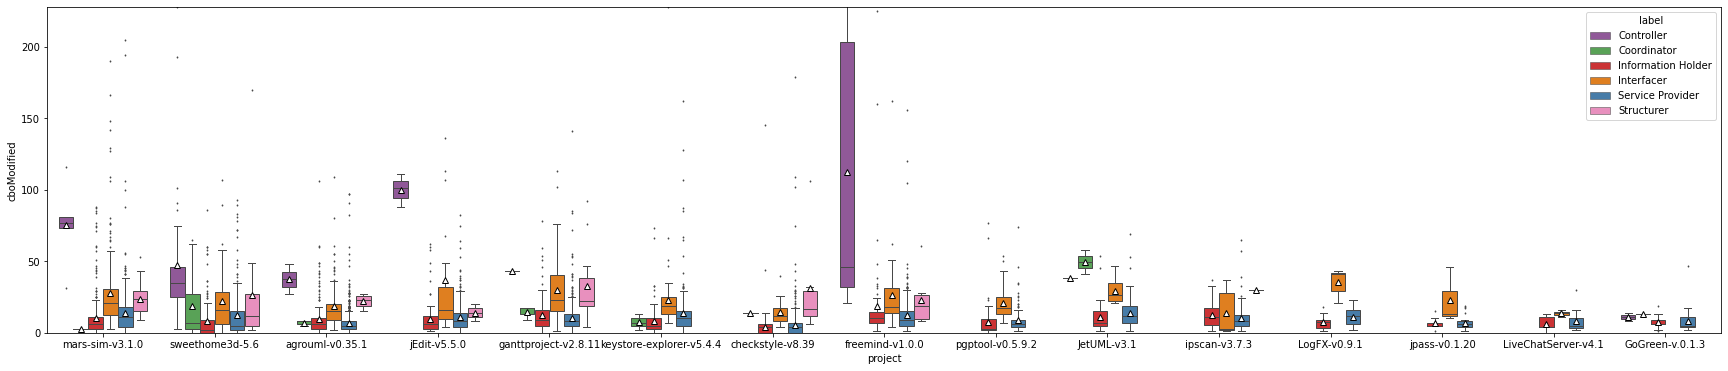

[fanin]
FAN-IN: Counts the number of input dependencies a class has, i.e, the number of classes that reference a particular class. For instance, given a class X, the fan-in of X would be the number of classes that call X by referencing it as an attribute, accessing some of its attributes, invoking some of its methods, etc.


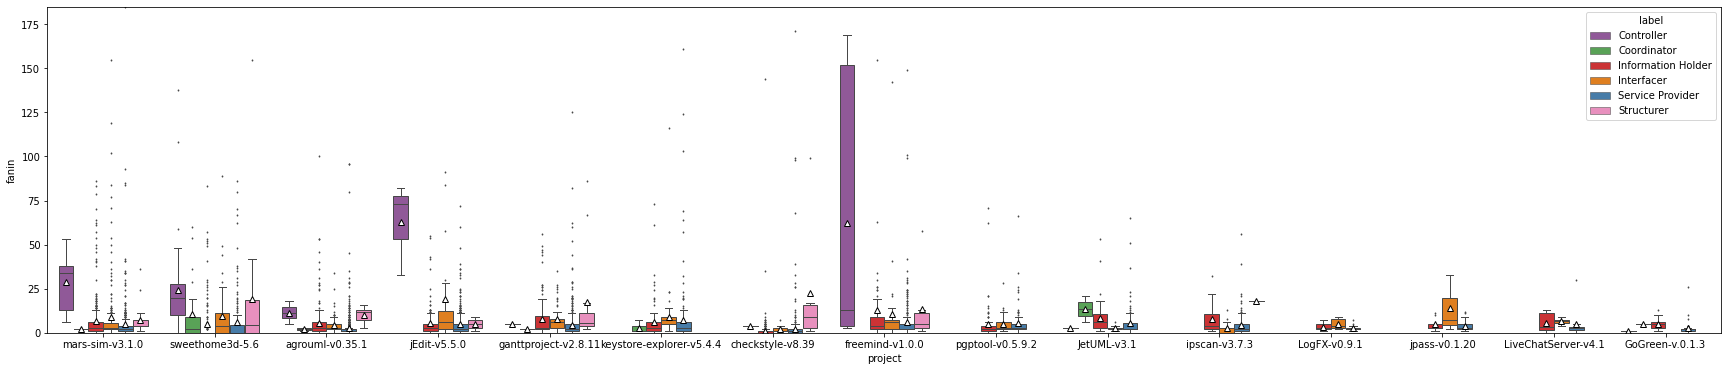

[fanout]
FAN-OUT: Counts the number of output dependencies a class has, i.e, the number of other classes referenced by a particular class. In other words, given a class X, the fan-out of X is the number of classes called by X via attributes reference, method invocations, object instances, etc.


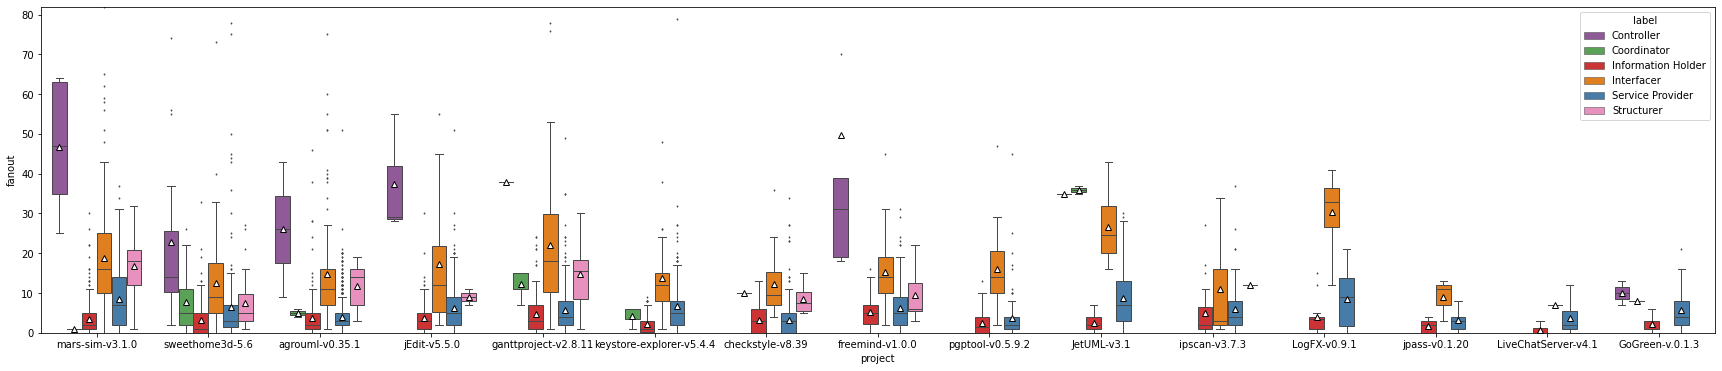

[wmc]
WMC (Weight Method Class) or McCabe's complexity. It counts the number of branch instructions in a class.


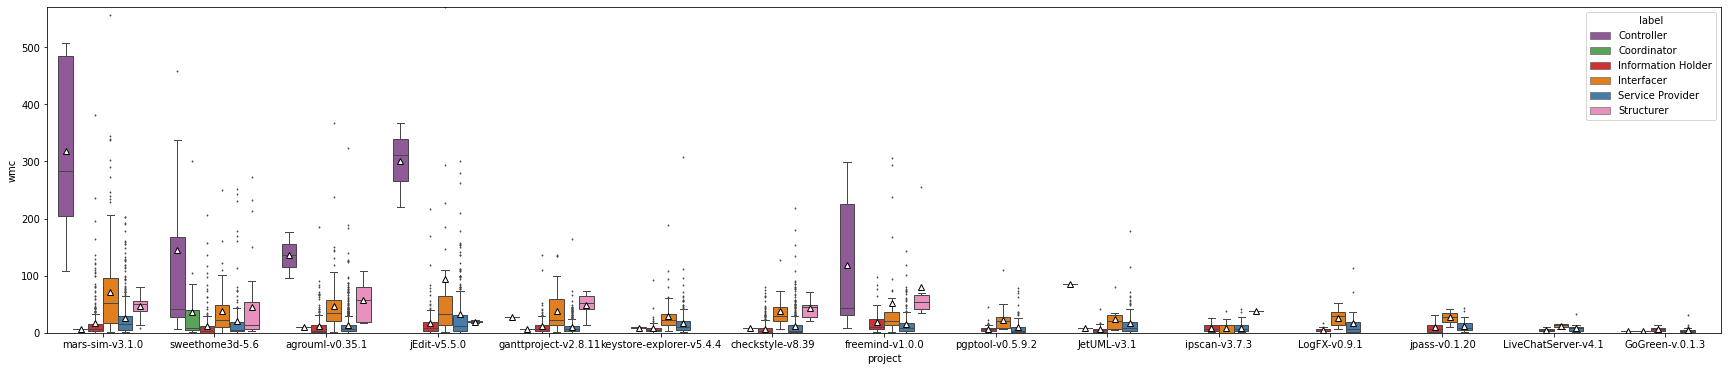

[dit]
DIT (Depth Inheritance Tree): It counts the number of "fathers" a class has. All classes have DIT at least 1 (everyone inherits java.lang.Object). In order to make it happen, classes must exist in the project (i.e. if a class depends upon X which relies in a jar/dependency file, and X depends upon other classes, DIT is counted as 2).


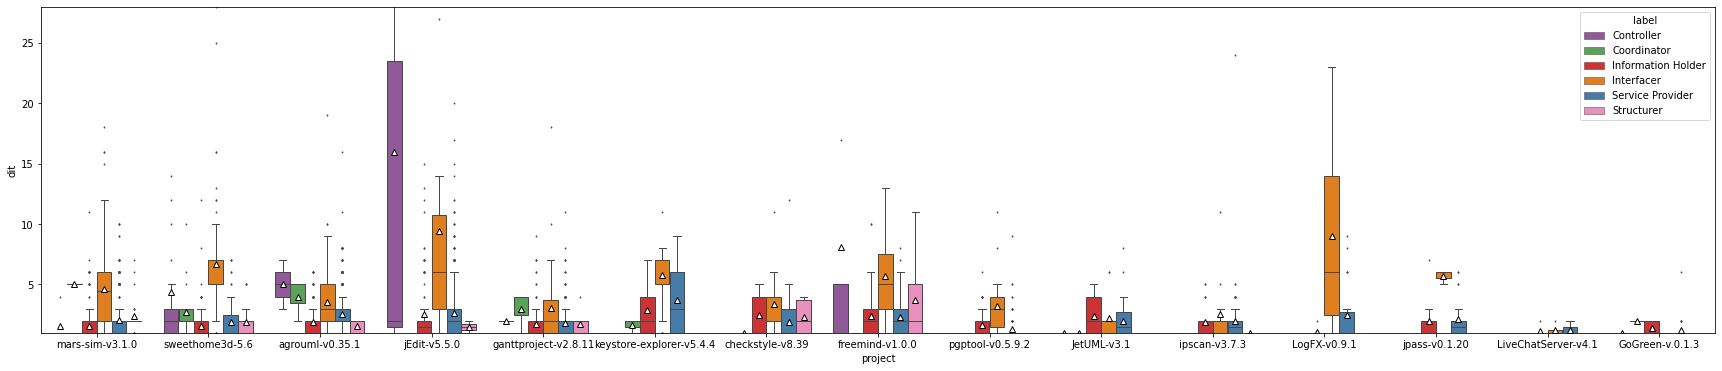

[noc]
NOC (Number of Children): It counts the number of immediate subclasses that a particular class has.


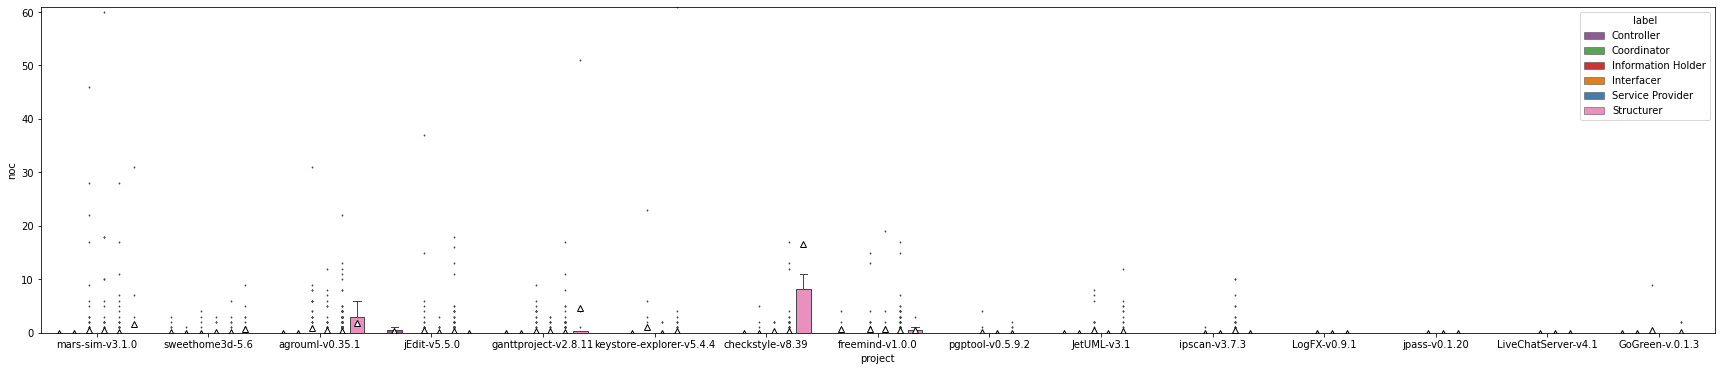

[rfc]
RFC (Response for a Class): Counts the number of unique method invocations in a class. As invocations are resolved via static analysis, this implementation fails when a method has overloads with same number of parameters, but different types.


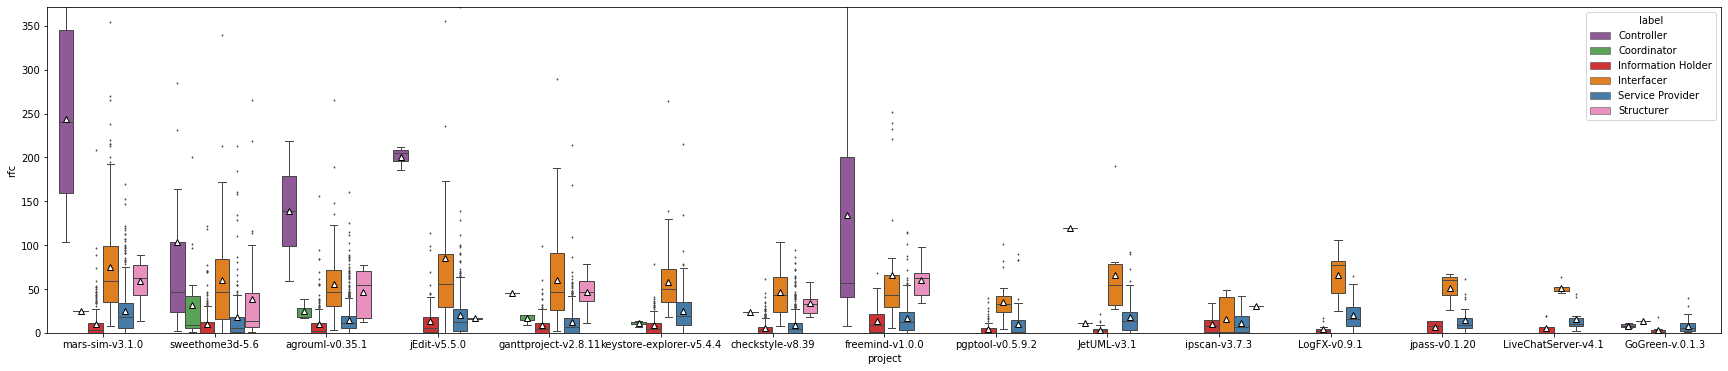

[lcom*]
LCOM* (Lack of Cohesion of Methods): This metric is a modified version of the current version of LCOM implemented in CK Tool. LCOM* is a normalized metric that computes the lack of cohesion of class within a range of 0 to 1. Then, the closer to 1 the value of LCOM* in a class, the less the cohesion degree of this respective class. The closer to 0 the value of LCOM* in a class, the most the cohesion of this respective class. This implementation follows the third version of LCOM* defined in [1]. Reference: [1] Henderson-Sellers, Brian, Larry L. Constantine and Ian M. Graham. “Coupling and cohesion (towards a valid metrics suite for object-oriented analysis and design).” Object Oriented Systems 3 (1996): 143-158.


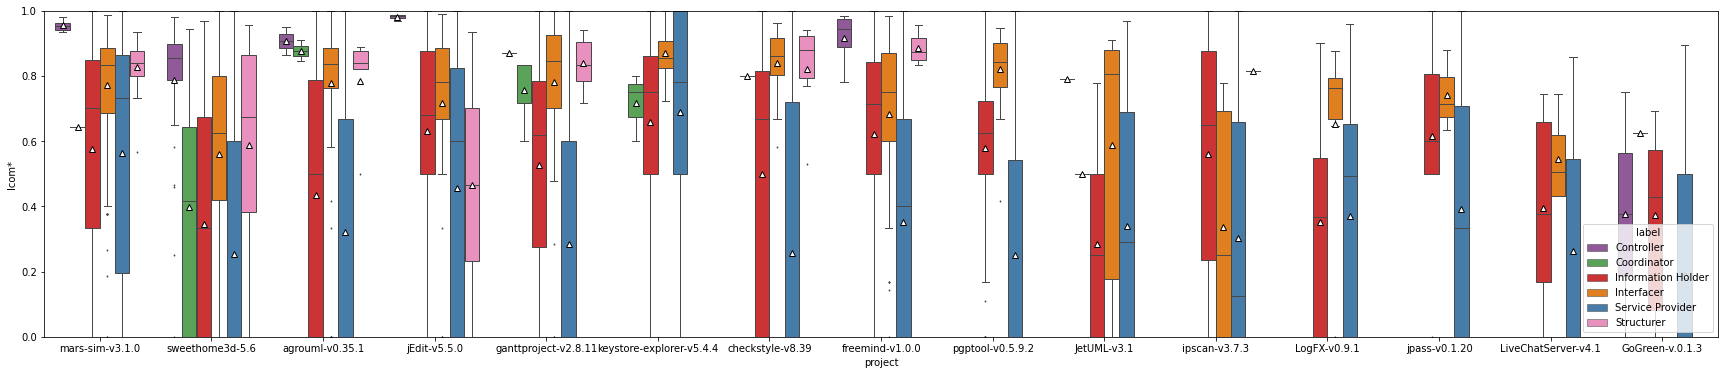

[tcc]
TCC (Tight Class Cohesion): Measures the cohesion of a class with a value range from 0 to 1. TCC measures the cohesion of a class via direct connections between visible methods, two methods or their invocation trees access the same class variable.


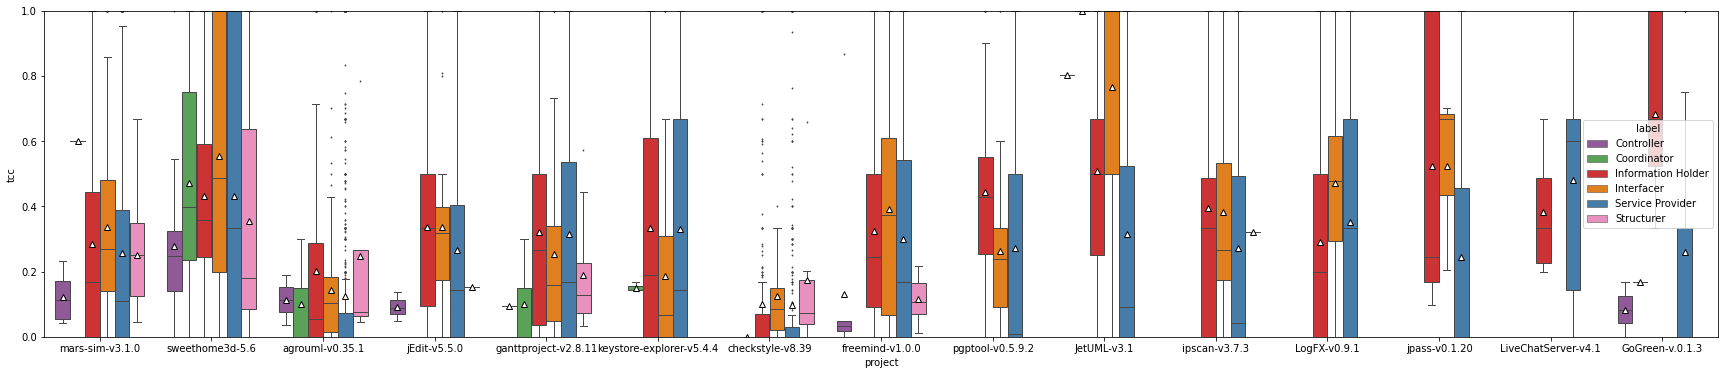

[lcc]
LCC (Loose Class Cohesion): Similar to TCC but it further includes the number of indirect connections between visible classes for the cohesion calculation. Thus, the constraint LCC >= TCC holds always.


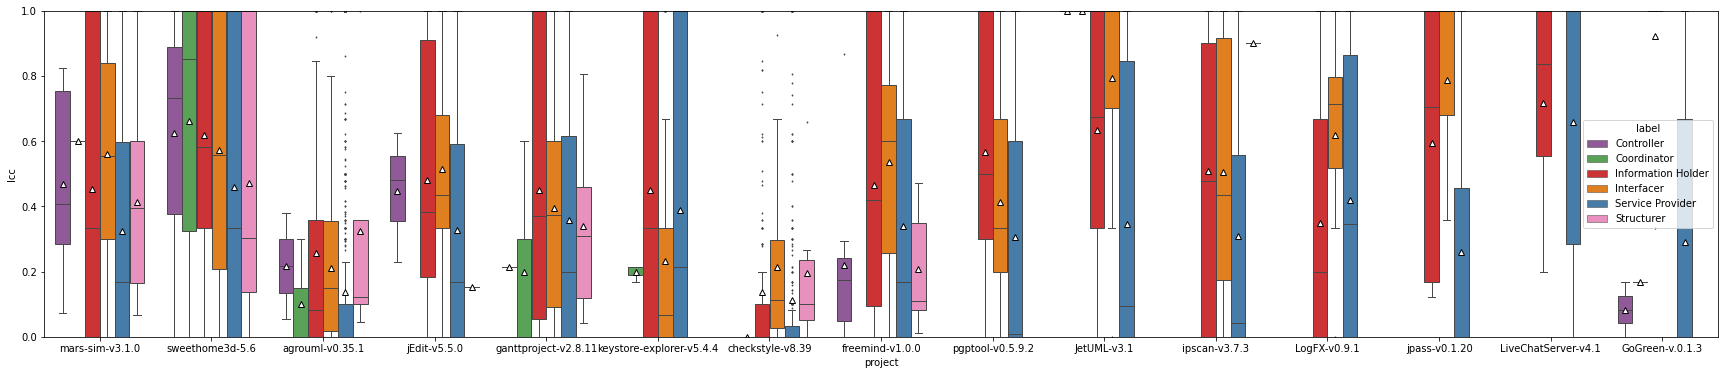

[totalMethodsQty]


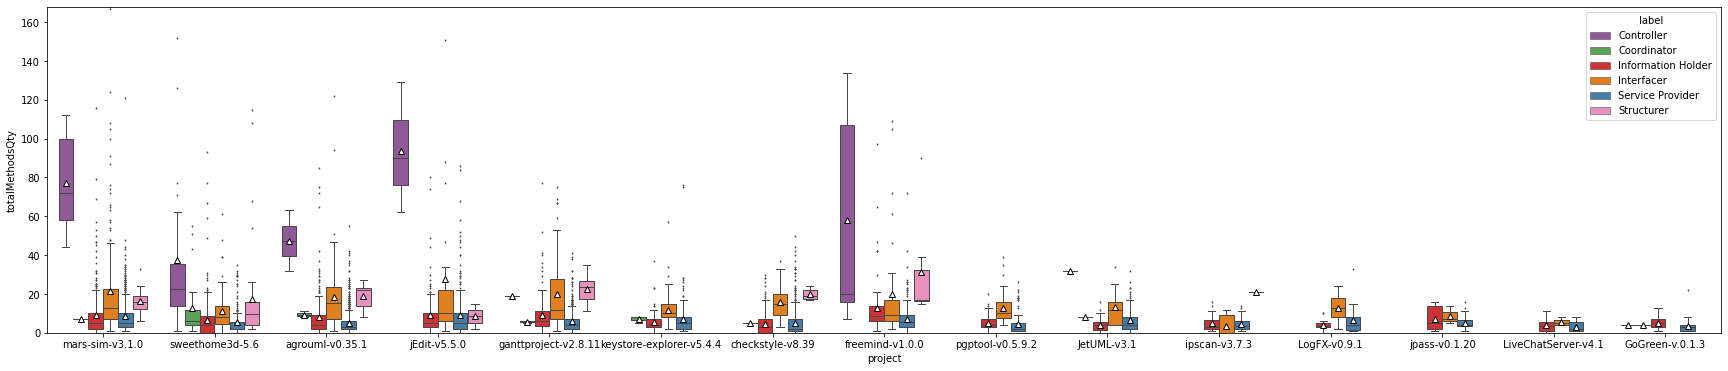

[publicMethodsQty]


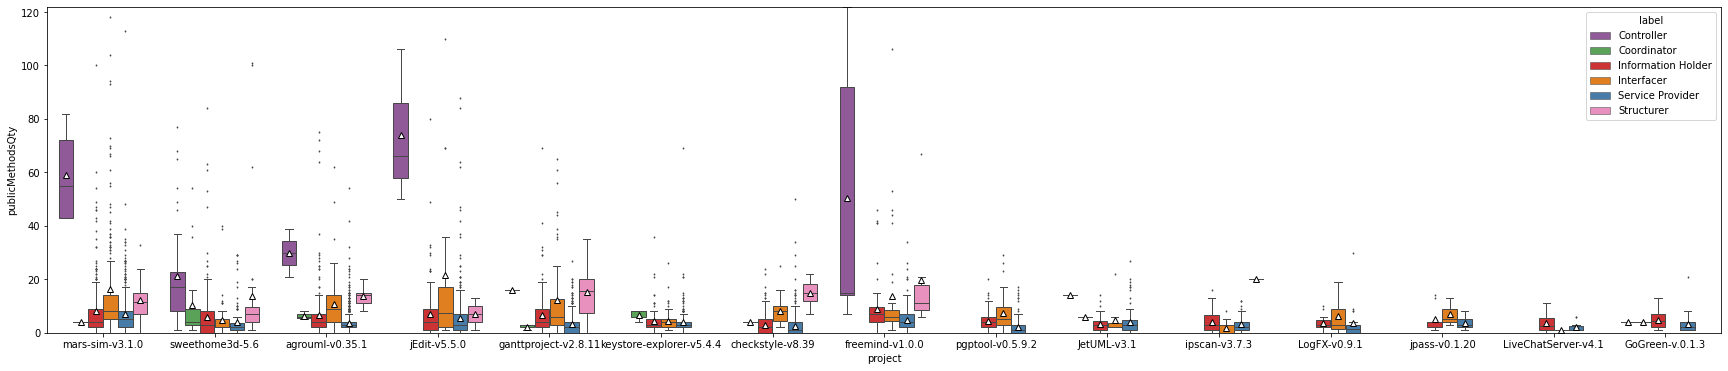

[privateMethodsQty]


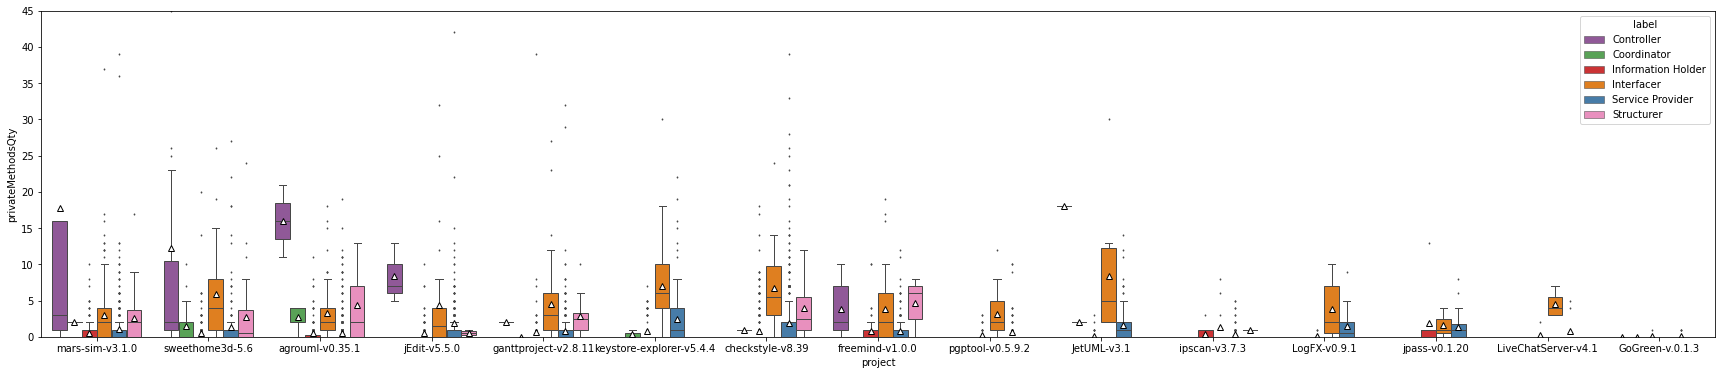

[abstractMethodsQty]


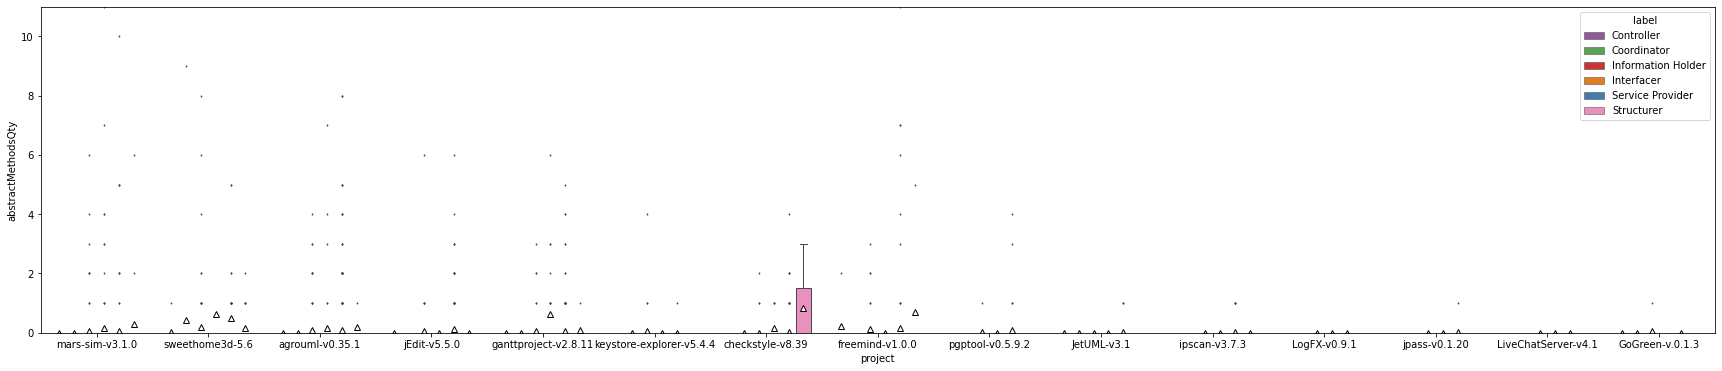

[finalMethodsQty]


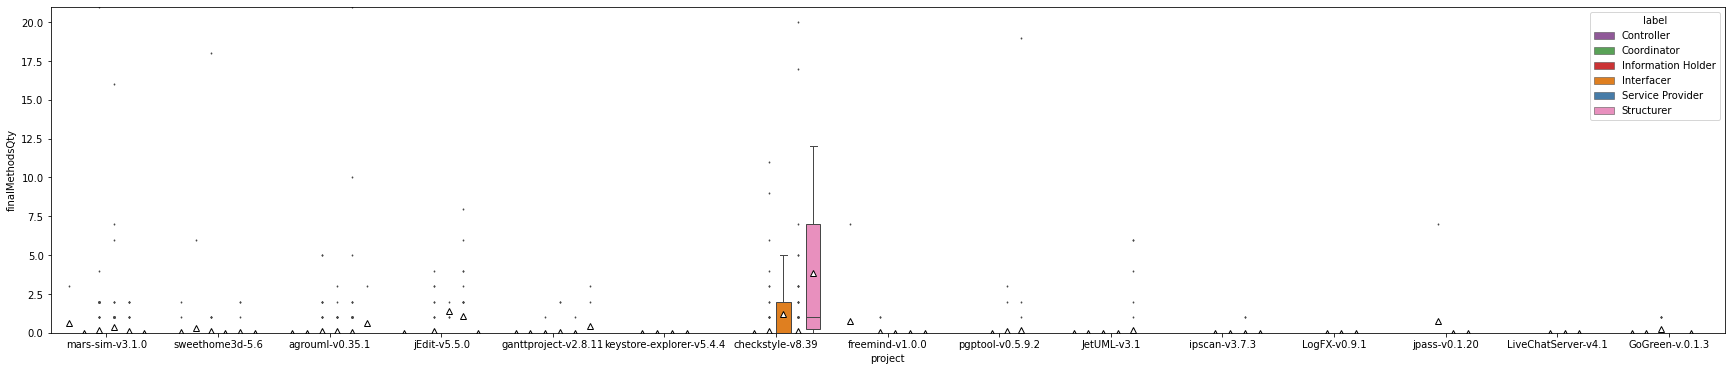

[totalFieldsQty]


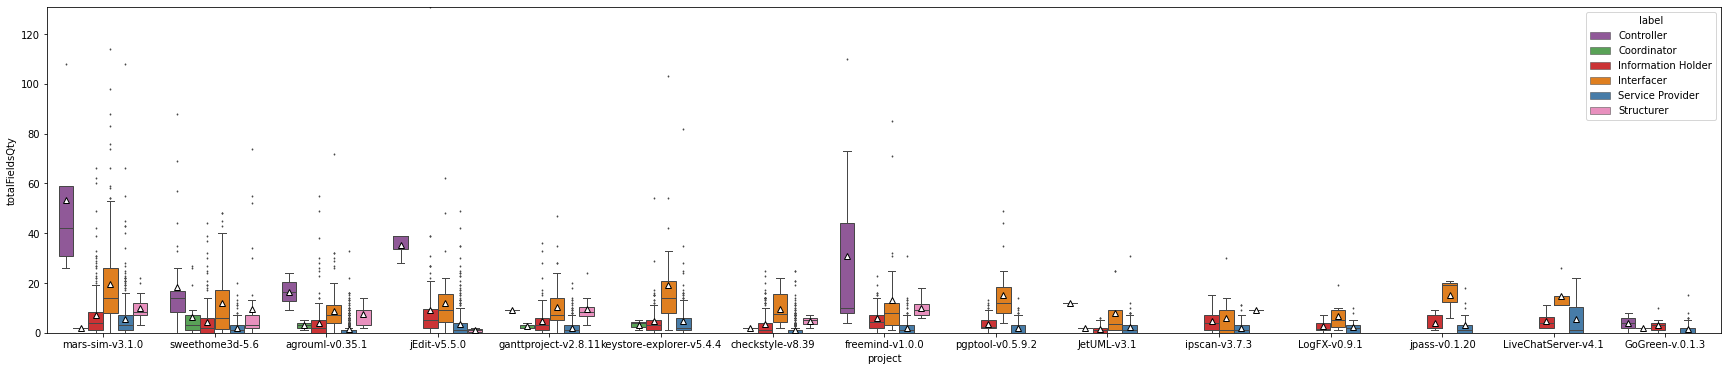

[publicFieldsQty]


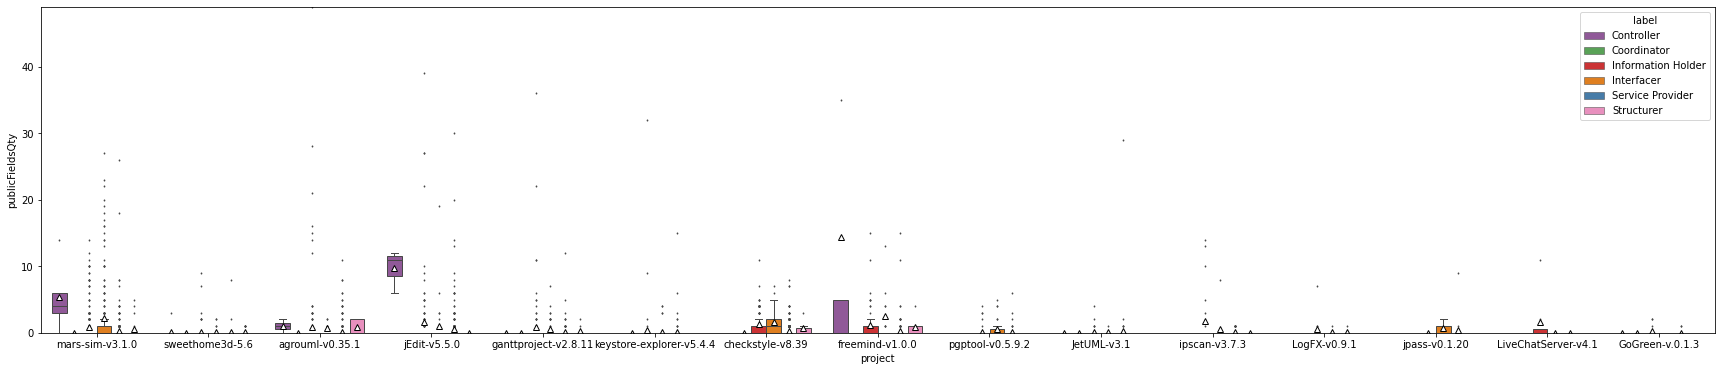

[privateFieldsQty]


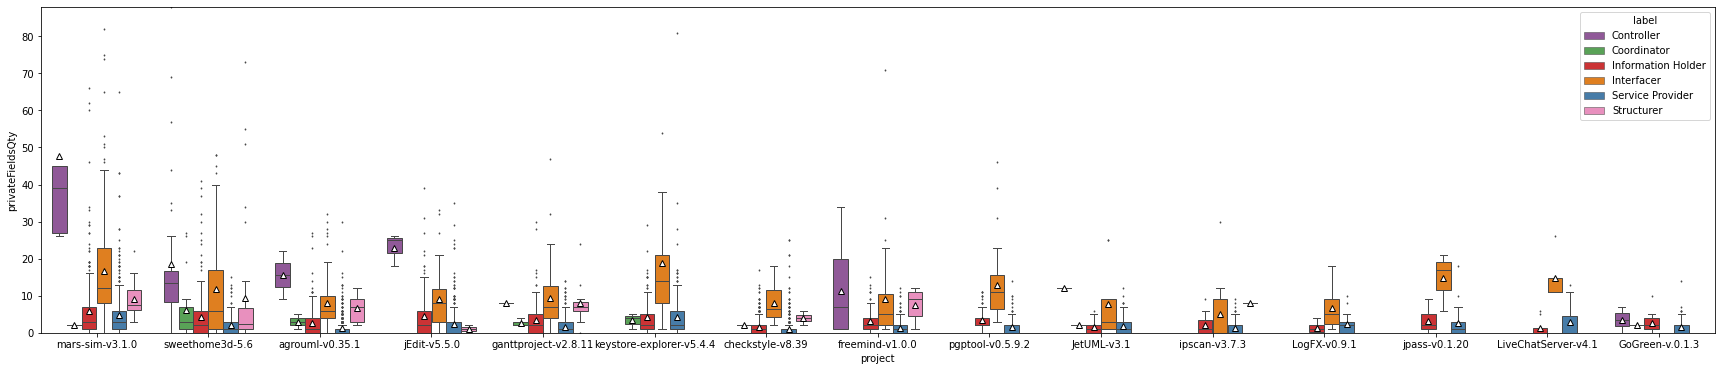

[finalFieldsQty]


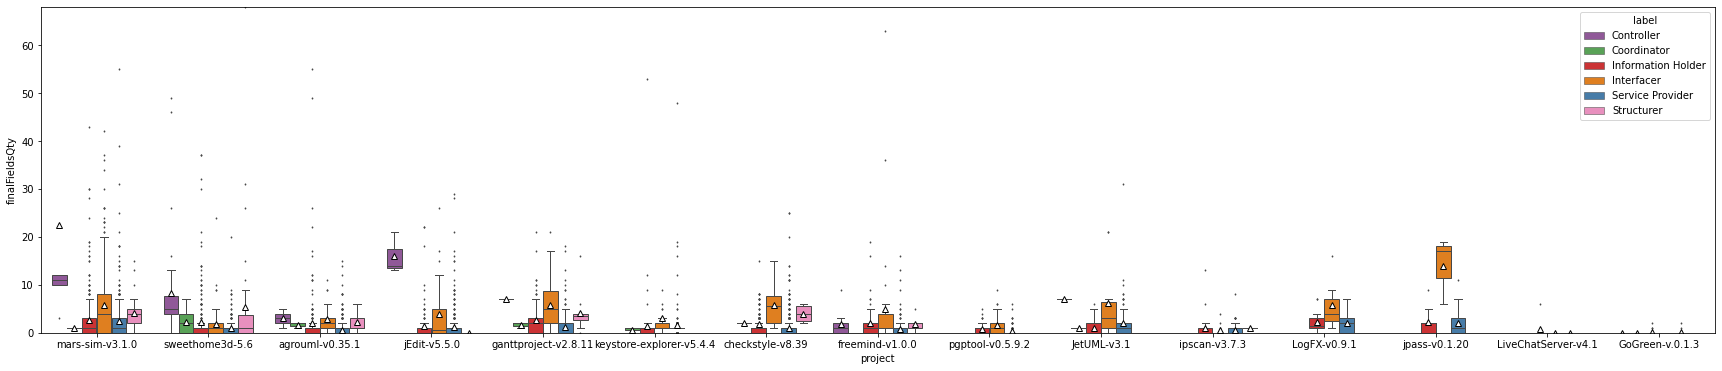

[nosi]
NOSI (Number of static invocations): Counts the number of invocations to static methods. It can only count the ones that can be resolved by the JDT.


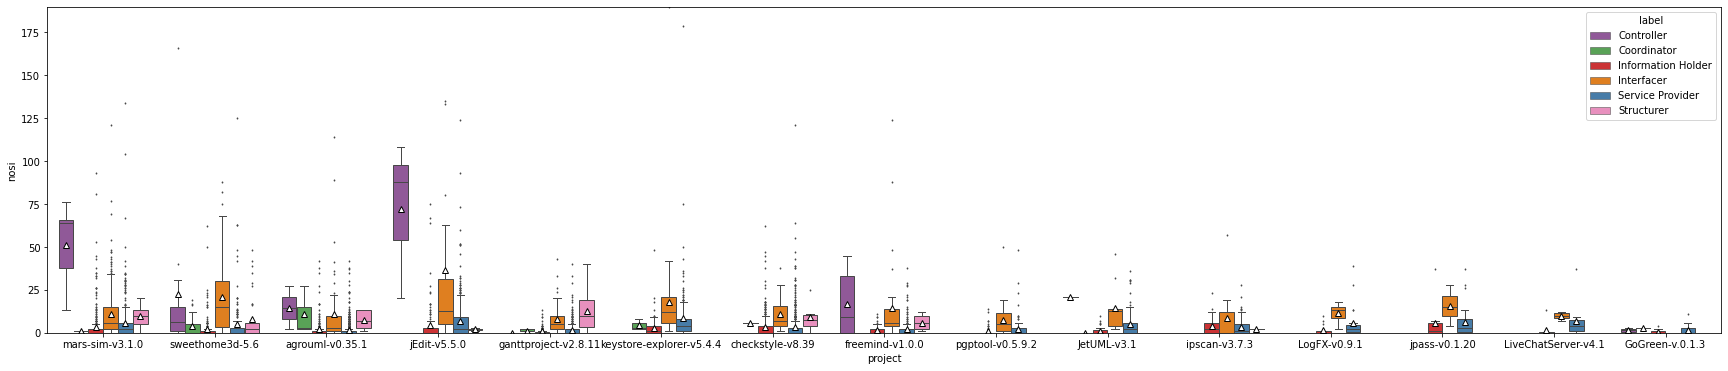

[loc]
LOC (Lines of code): It counts the lines of count, ignoring empty lines and comments (i.e., it's Source Lines of Code, or SLOC). The number of lines here might be a bit different from the original file, as we use JDT's internal representation of the source code to calculate it.


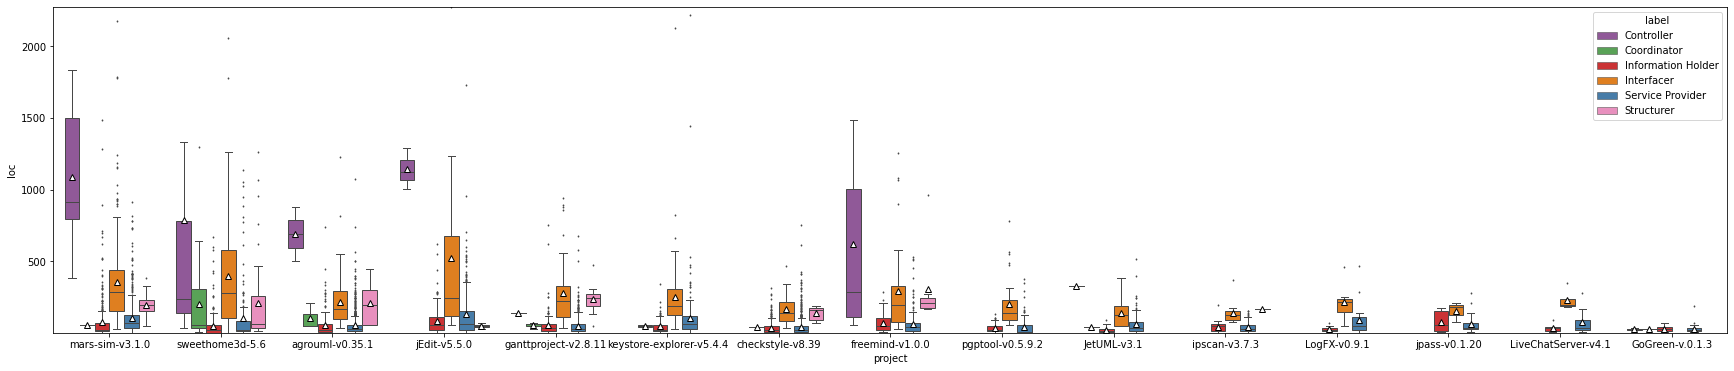

[returnQty]
Quantity of returns: The number of return instructions.


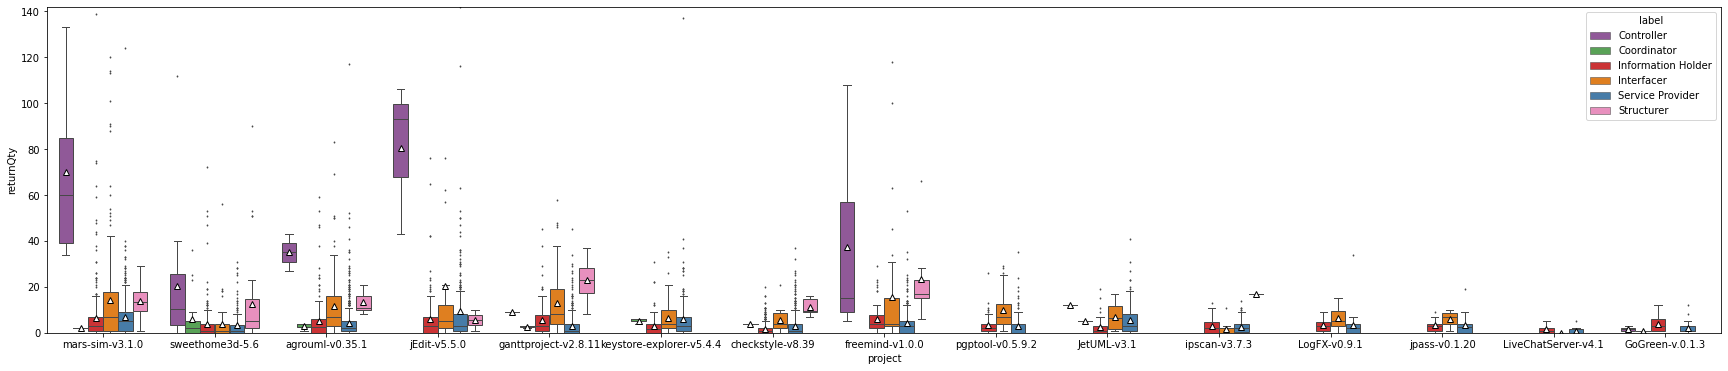

[loopQty]
Quantity of loops: The number of loops (i.e., for, while, do while, enhanced for).


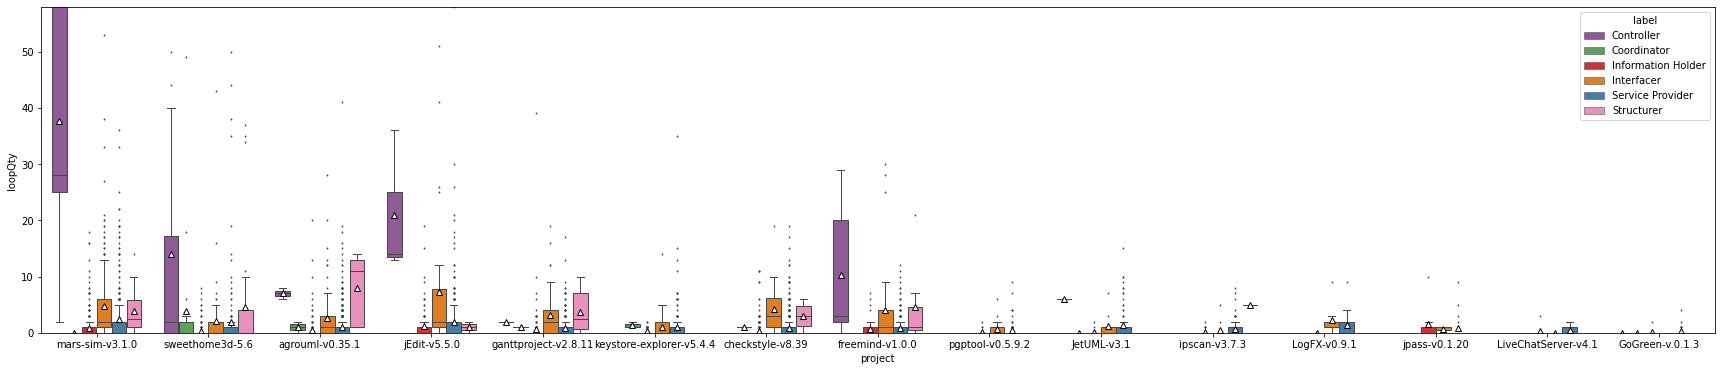

[comparisonsQty]
Quantity of comparisons: The number of comparisons (i.e., == and !=). Note: != is only available in 0.4.2+.


[tryCatchQty]
Quantity of try/catches: The number of try/catches


[parenthesizedExpsQty]
Quantity of parenthesized expressions: The number of expressions inside parenthesis.


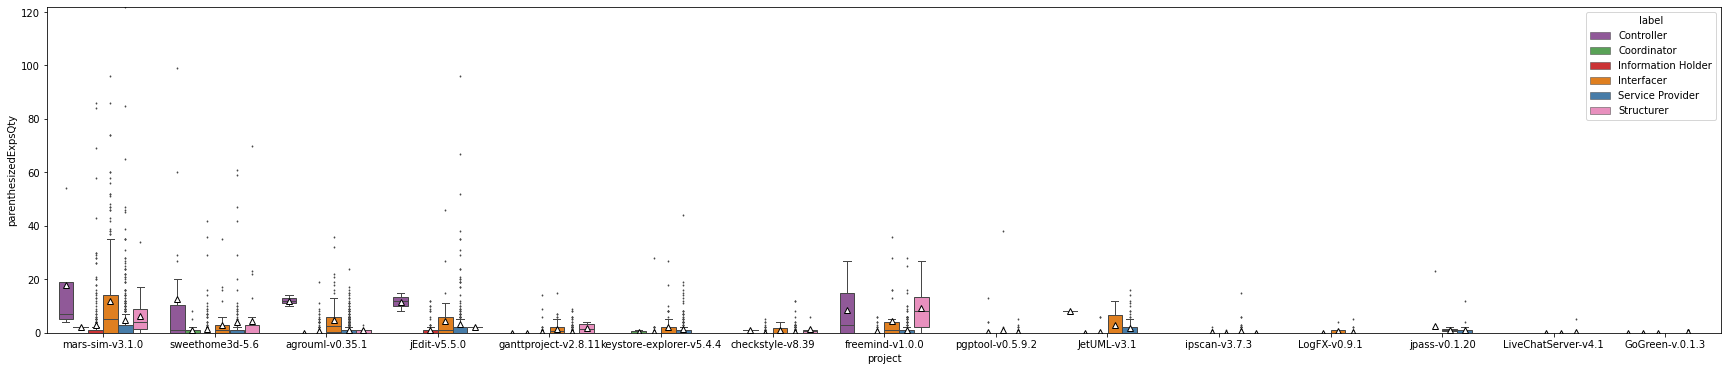

[stringLiteralsQty]
String literals: The number of string literals (e.g., "John Doe"). Repeated strings count as many times as they appear.


[numbersQty]
Quantity of Number: The number of numbers (i.e., int, long, double, float) literals.


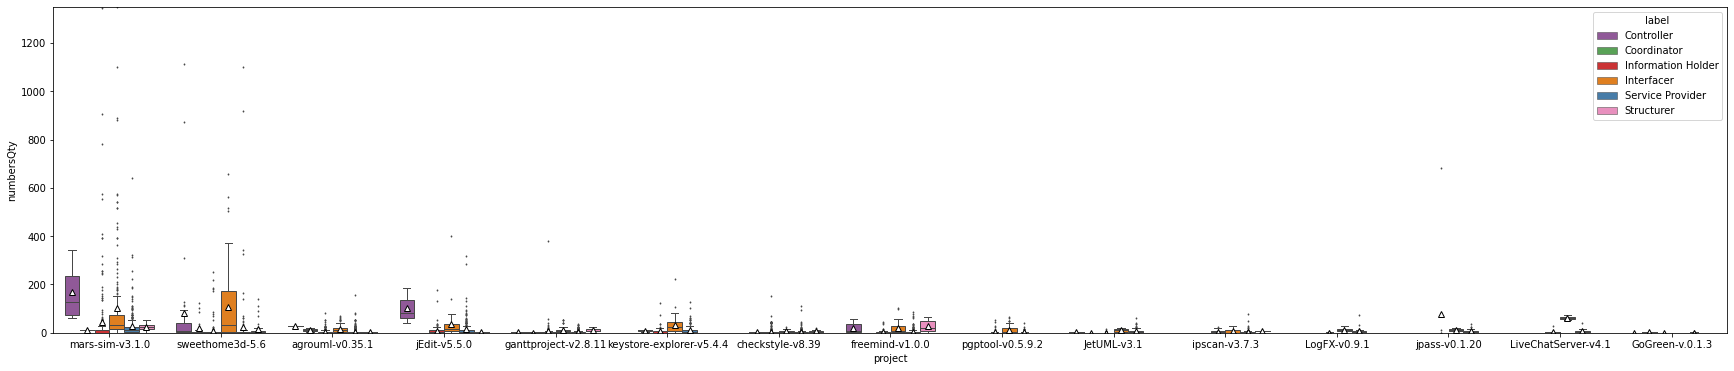

[assignmentsQty]


[mathOperationsQty]
Quantity of Math Operations: The number of math operations (times, divide, remainder, plus, minus, left shit, right shift).


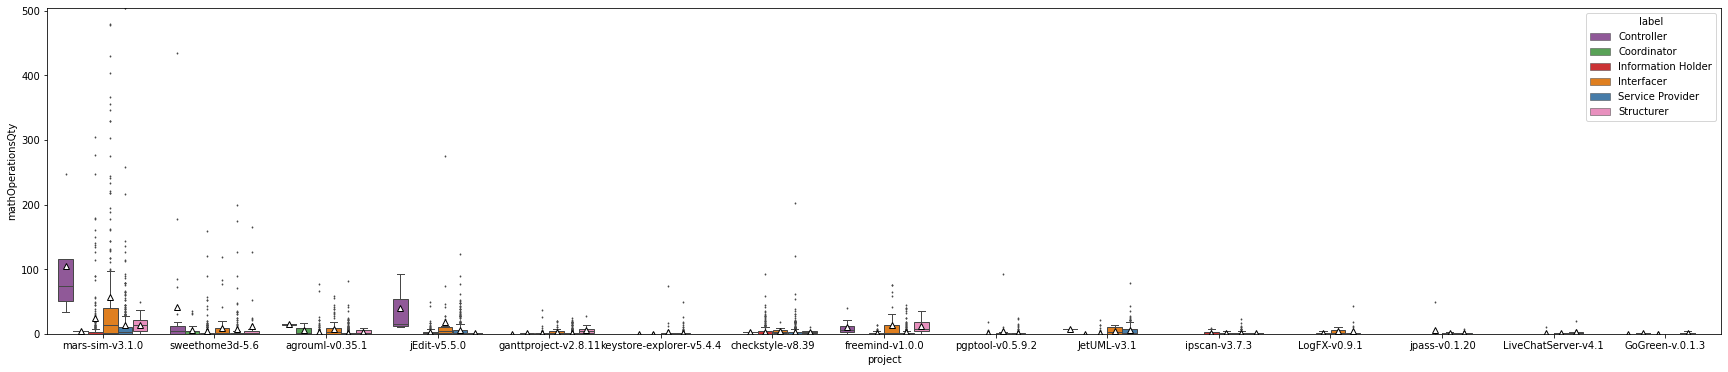

[variablesQty]
Quantity of Variables: Number of declared variables.


[maxNestedBlocksQty]
Max nested blocks: The highest number of blocks nested together.


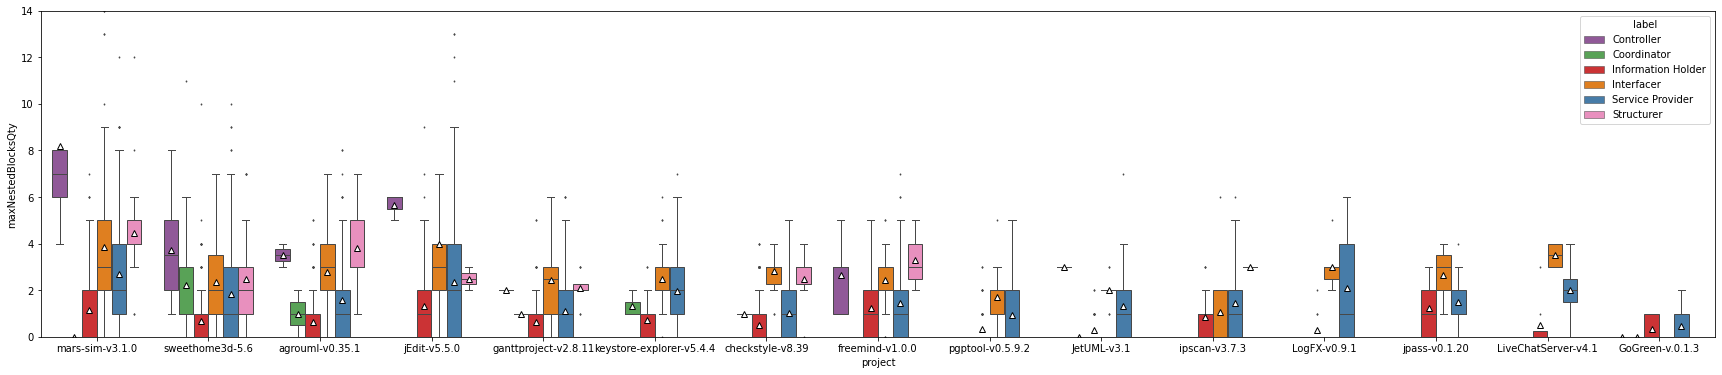

[anonymousClassesQty]
Quantity of Anonymous classes, inner classes, and lambda expressions: The name says it all. Note that whenever an anonymous class or an inner class is declared, it becomes an "entire new class", e.g., CK generates A.B and A.B$C, C being an inner class inside A.B. However, lambda expressions are not considered classes, and thus, are part of the class/method they are embedded into. A class or a method only has the number of inner classes that are declared at its level, e.g., an inner class that is declared inside a method M2, that is inside an anonymous class A, that is declared inside a method M, that finally is declared inside a class C, will not count in class C, but only in method M2 (first-level method it is embodied), and anonymous class A (first-level class it is embodied).


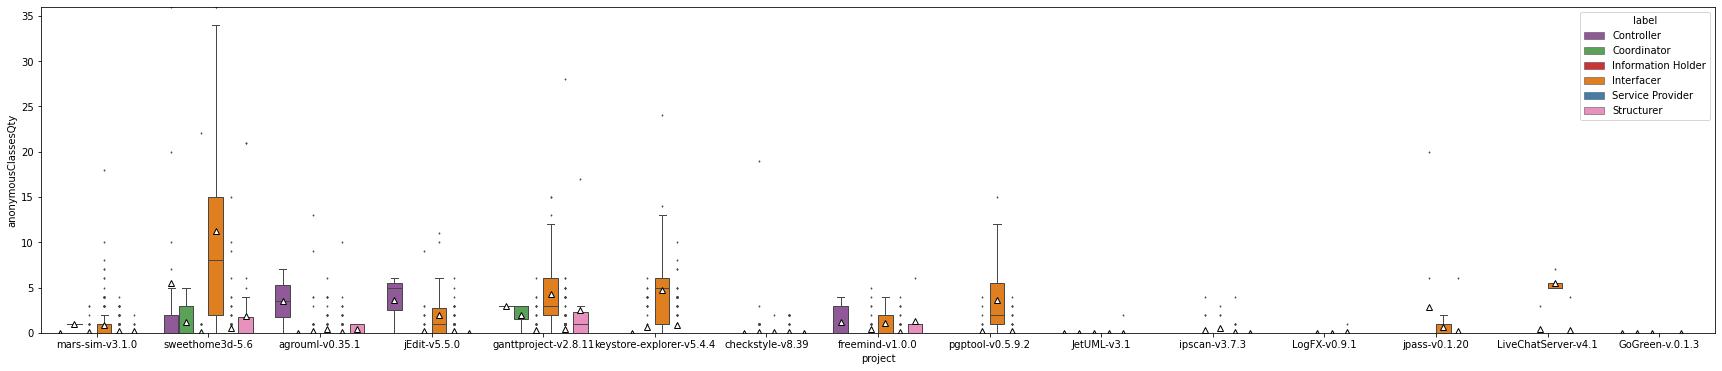

[innerClassesQty]


[lambdasQty]


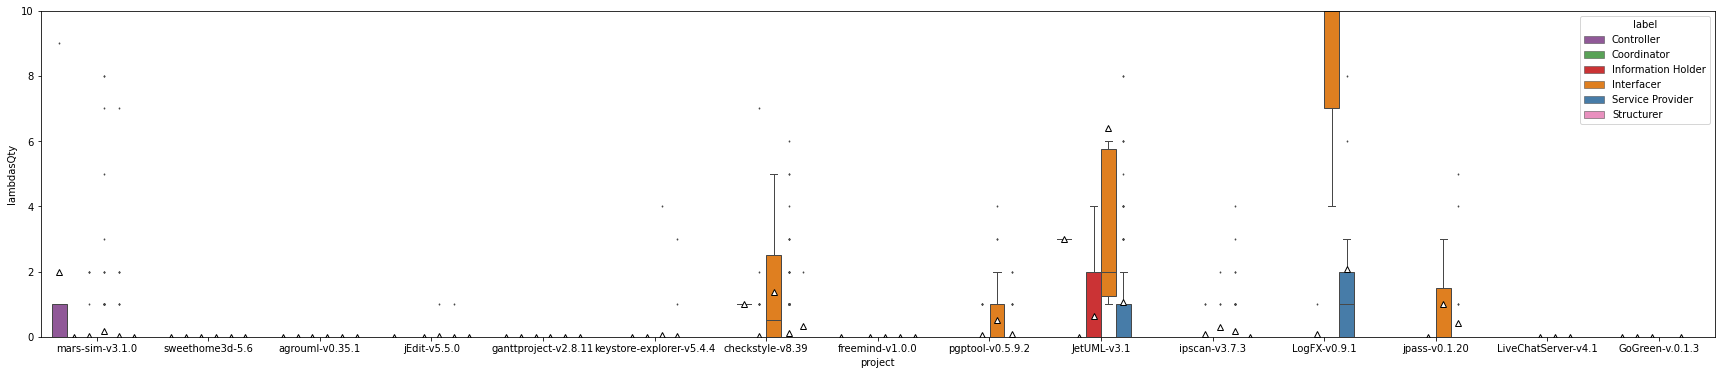

[uniqueWordsQty]
Number of unique words: Number of unique words in the source code. At method level, it only uses the method body as input. At class level, it uses the entire body of the class as metrics. The algorithm basically counts the number of words in a method/class, after removing Java keywords. Names are split based on camel case and underline (e.g., longName_likeThis becomes four words). See WordCounter class for details on the implementation.


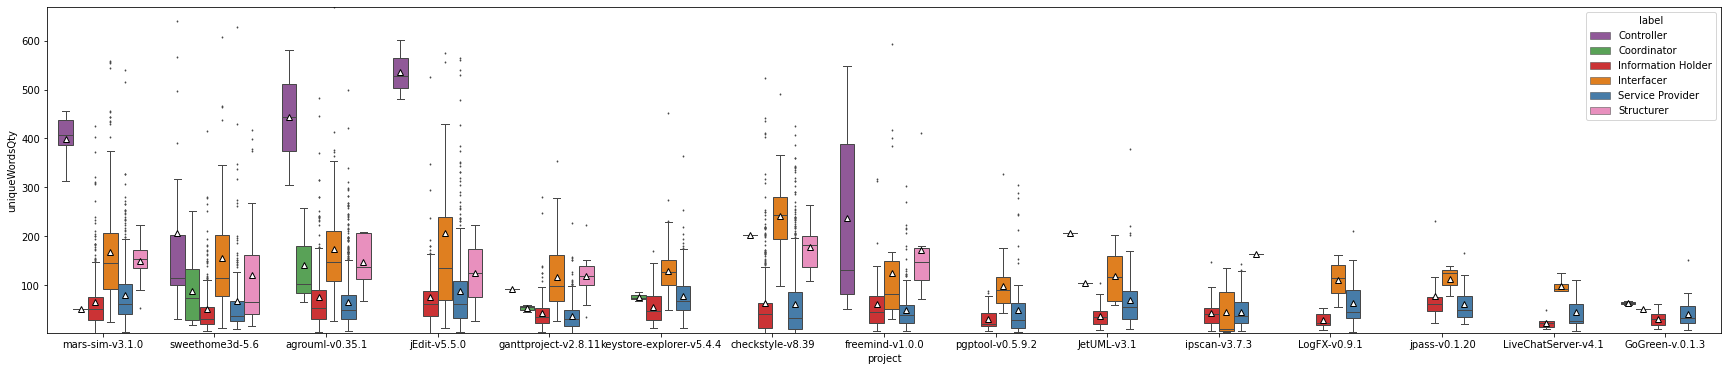

[ratio_publicMethods]


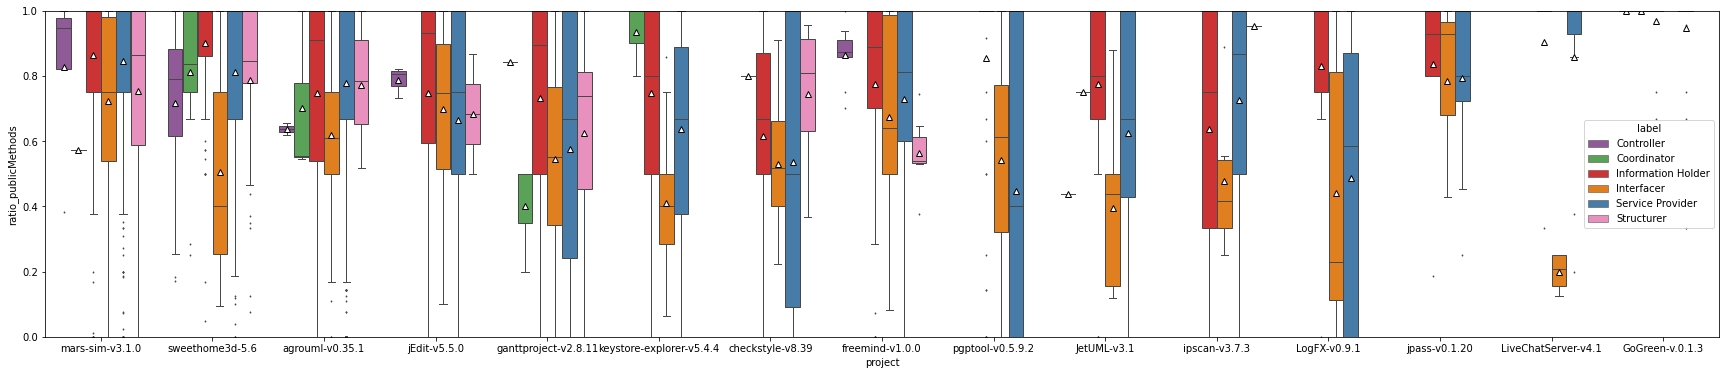

[ratio_privateMethods]


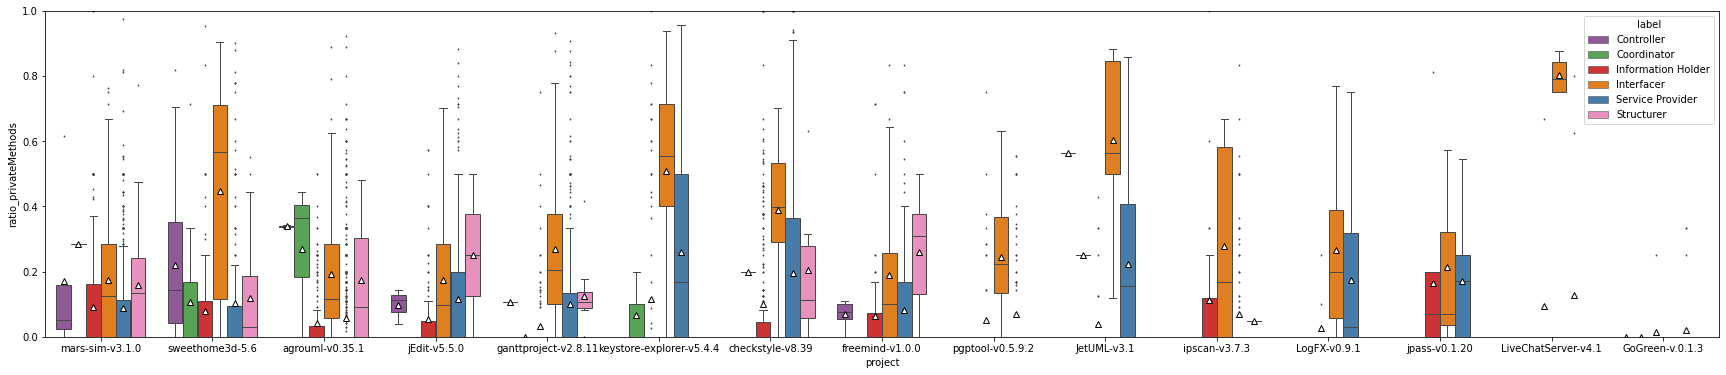

[ratio_publicFields]


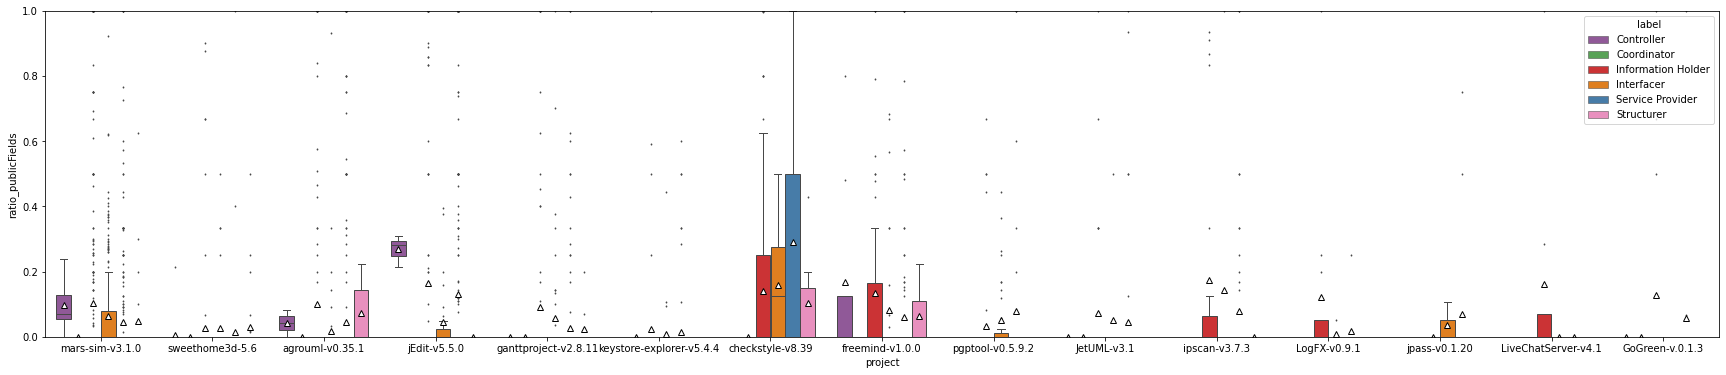

[ratio_privateFields]


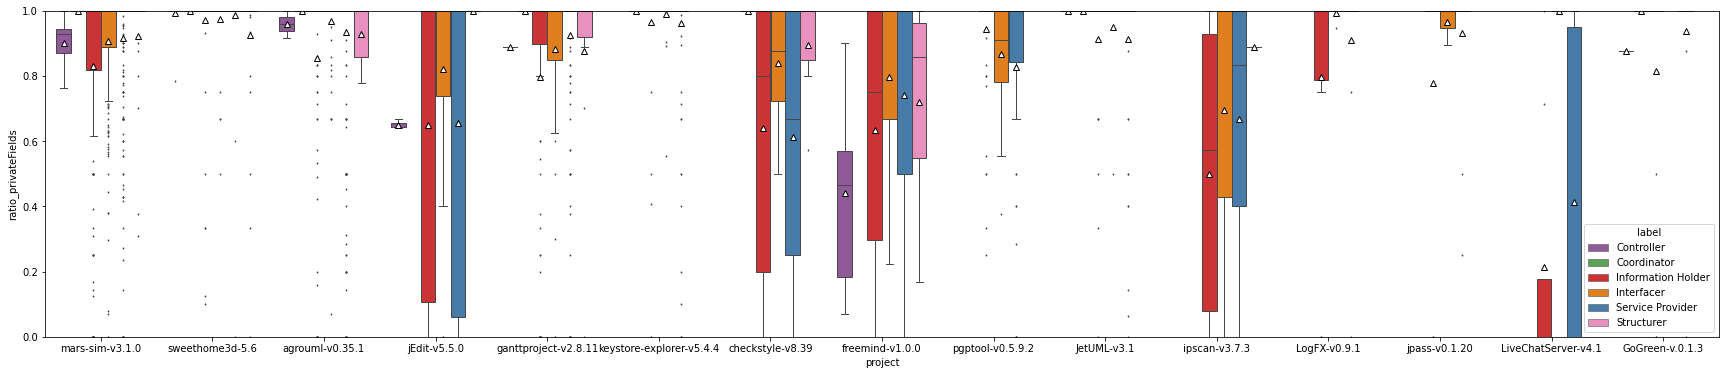

In [10]:
i = 0
for metric in metrics:
  plt.figure(i, figsize=(30,6))
  print(f"[{metric}]")
  if metric in metrics_def.keys():
    print(metrics_def[metric])
  g = sns.boxplot(x="project", y=metric,
      hue="label", palette=rs.dpalette(), 
      hue_order=rstr,
      order=prj_order,
      linewidth=1, fliersize=1,
      showmeans=True,
      meanprops = {"markerfacecolor":"white", "markeredgecolor": "black"},
      data=alldf)
  mn = alldf[metric].min()
  mx = alldf.quantile(.999, interpolation="higher")[metric]
  g.set(ylim=(mn,mx))
  plt.show()
  i += 1

[cbo]
CBO (Coupling between objects): Counts the number of dependencies a class has. The tools checks for any type used in the entire class (field declaration, method return types, variable declarations, etc). It ignores dependencies to Java itself (e.g. java.lang.String).


[cboModified]
CBO Modified (Coupling between objects): Counts the number of dependencies a class has. It is very similar to the CKTool's original CBO. However, this metric considers a dependency from a class as being both the references the type makes to others and the references that it receives from other types.


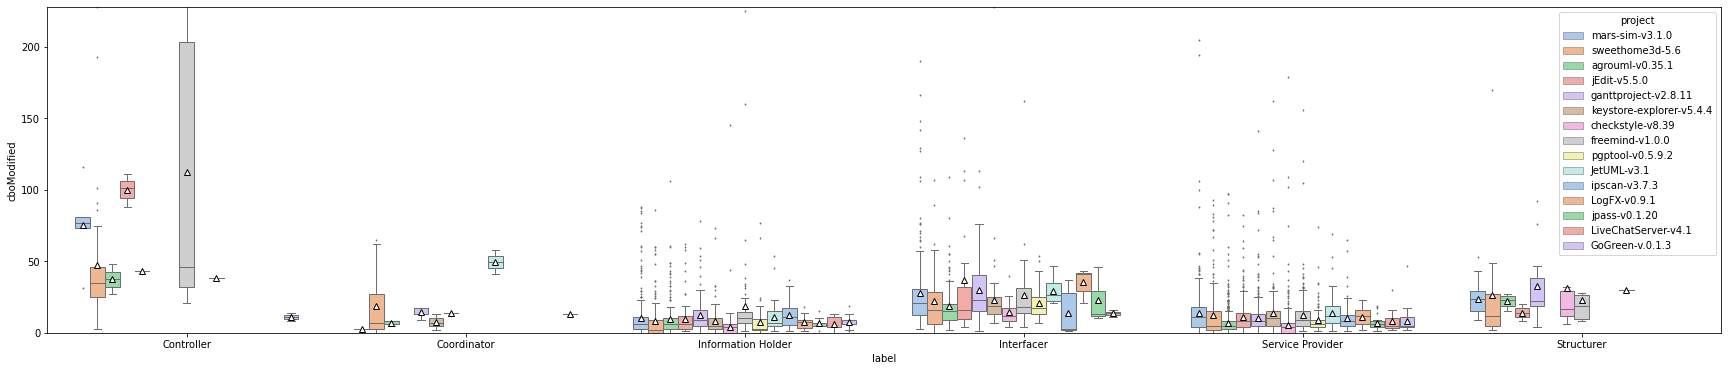

[fanin]
FAN-IN: Counts the number of input dependencies a class has, i.e, the number of classes that reference a particular class. For instance, given a class X, the fan-in of X would be the number of classes that call X by referencing it as an attribute, accessing some of its attributes, invoking some of its methods, etc.


[fanout]
FAN-OUT: Counts the number of output dependencies a class has, i.e, the number of other classes referenced by a particular class. In other words, given a class X, the fan-out of X is the number of classes called by X via attributes reference, method invocations, object instances, etc.


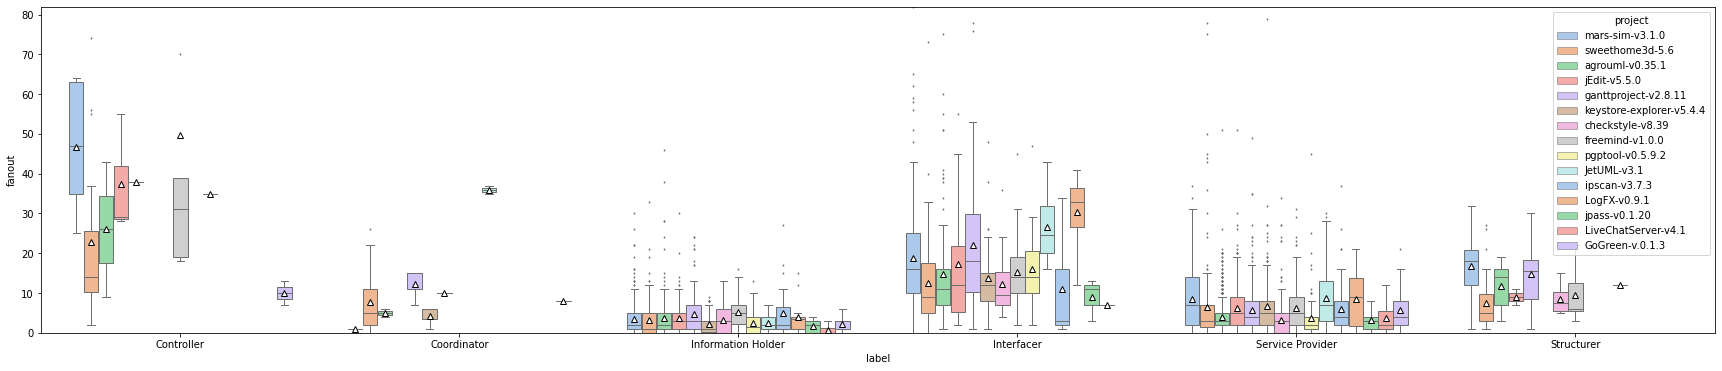

[wmc]
WMC (Weight Method Class) or McCabe's complexity. It counts the number of branch instructions in a class.


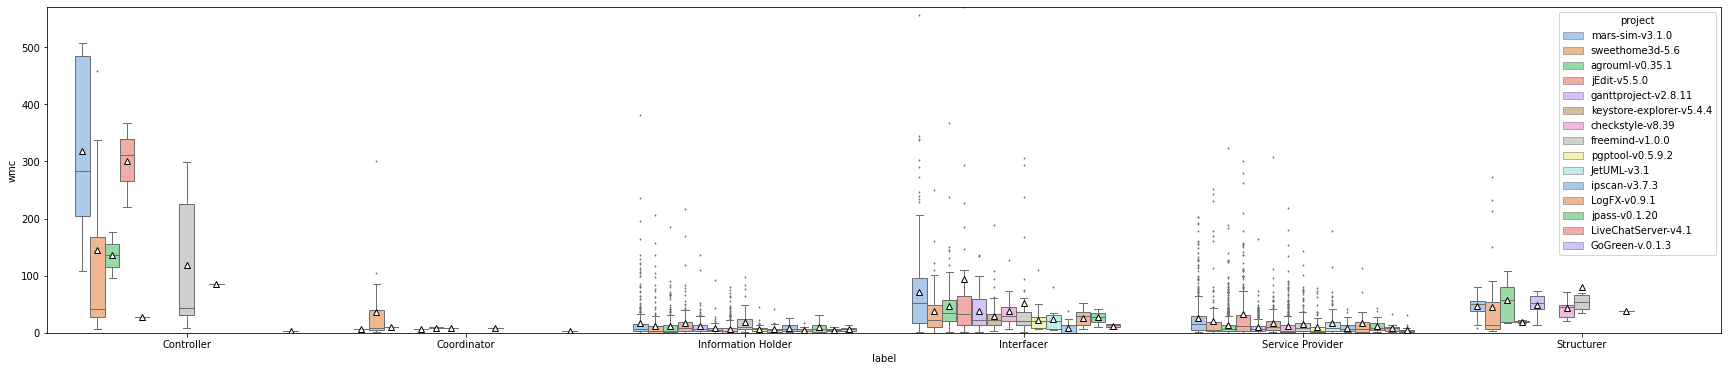

[dit]
DIT (Depth Inheritance Tree): It counts the number of "fathers" a class has. All classes have DIT at least 1 (everyone inherits java.lang.Object). In order to make it happen, classes must exist in the project (i.e. if a class depends upon X which relies in a jar/dependency file, and X depends upon other classes, DIT is counted as 2).


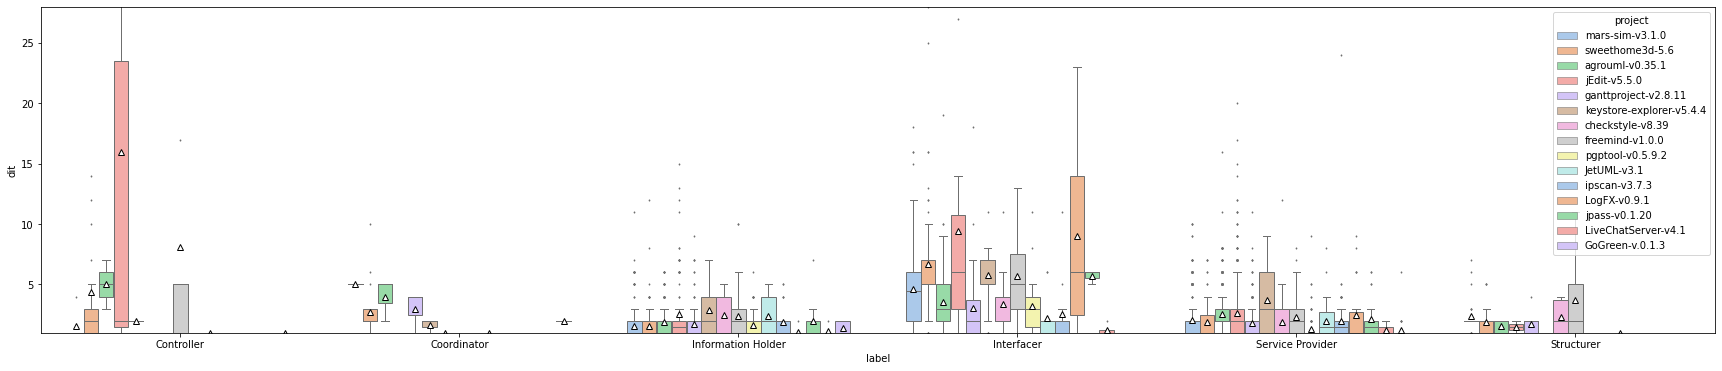

[noc]
NOC (Number of Children): It counts the number of immediate subclasses that a particular class has.


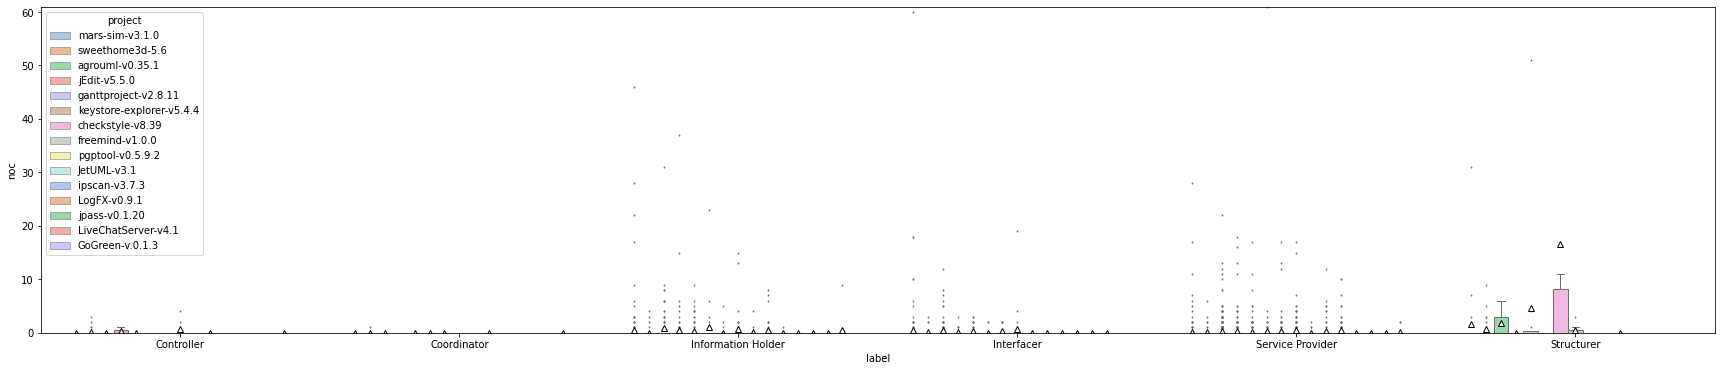

[rfc]
RFC (Response for a Class): Counts the number of unique method invocations in a class. As invocations are resolved via static analysis, this implementation fails when a method has overloads with same number of parameters, but different types.


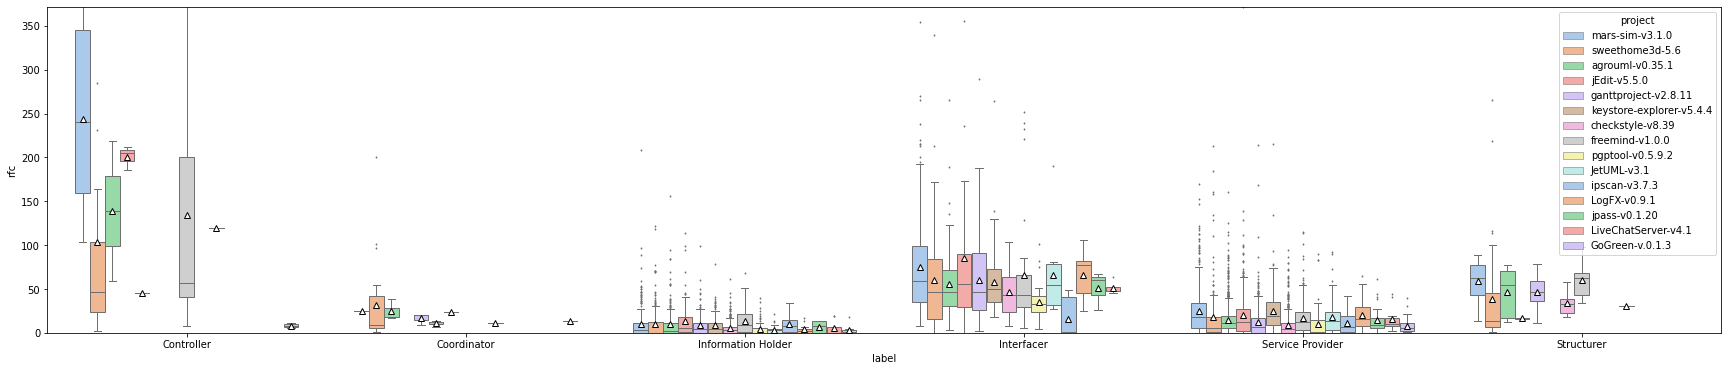

[lcom*]
LCOM* (Lack of Cohesion of Methods): This metric is a modified version of the current version of LCOM implemented in CK Tool. LCOM* is a normalized metric that computes the lack of cohesion of class within a range of 0 to 1. Then, the closer to 1 the value of LCOM* in a class, the less the cohesion degree of this respective class. The closer to 0 the value of LCOM* in a class, the most the cohesion of this respective class. This implementation follows the third version of LCOM* defined in [1]. Reference: [1] Henderson-Sellers, Brian, Larry L. Constantine and Ian M. Graham. “Coupling and cohesion (towards a valid metrics suite for object-oriented analysis and design).” Object Oriented Systems 3 (1996): 143-158.


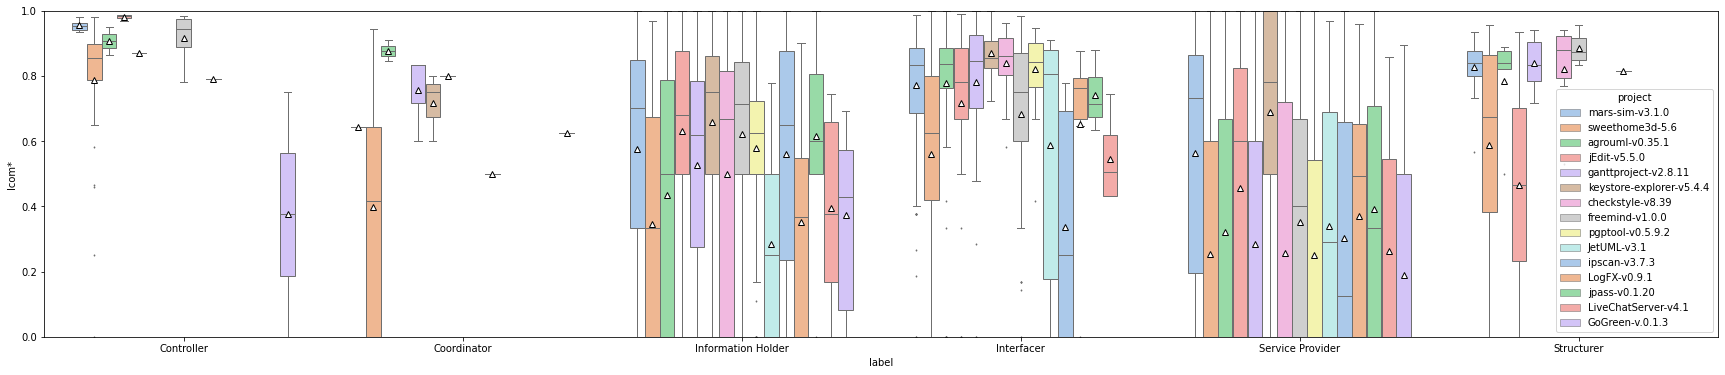

[tcc]
TCC (Tight Class Cohesion): Measures the cohesion of a class with a value range from 0 to 1. TCC measures the cohesion of a class via direct connections between visible methods, two methods or their invocation trees access the same class variable.


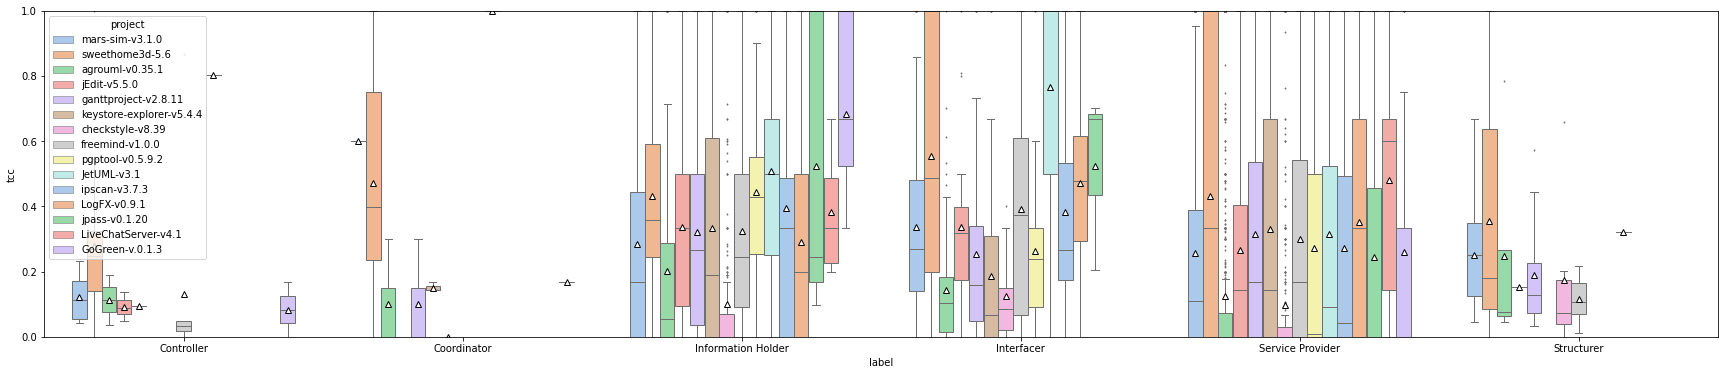

[lcc]
LCC (Loose Class Cohesion): Similar to TCC but it further includes the number of indirect connections between visible classes for the cohesion calculation. Thus, the constraint LCC >= TCC holds always.


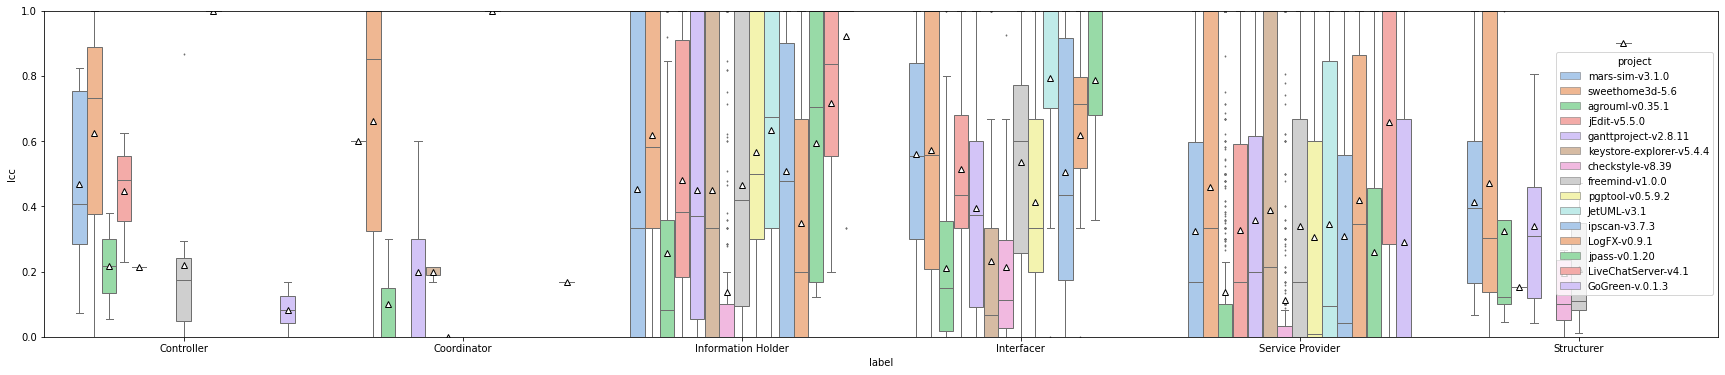

[totalMethodsQty]


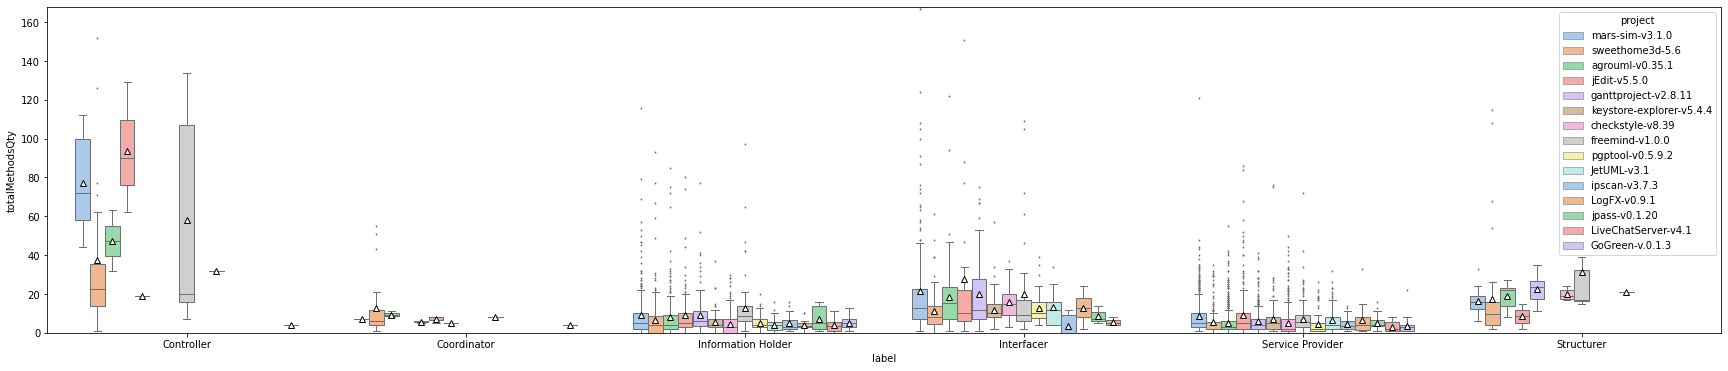

[publicMethodsQty]


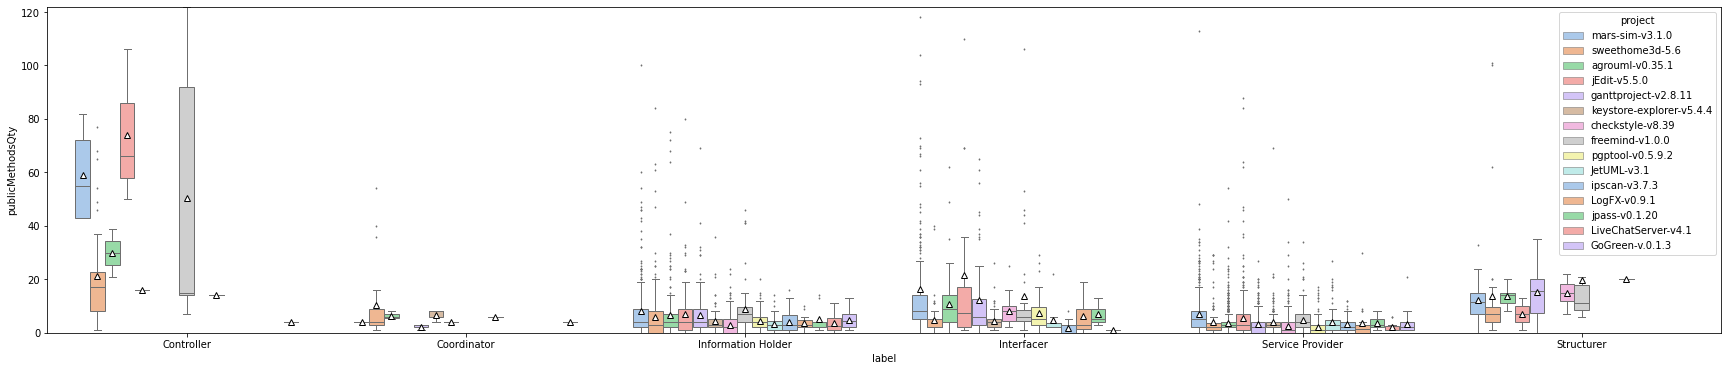

[privateMethodsQty]


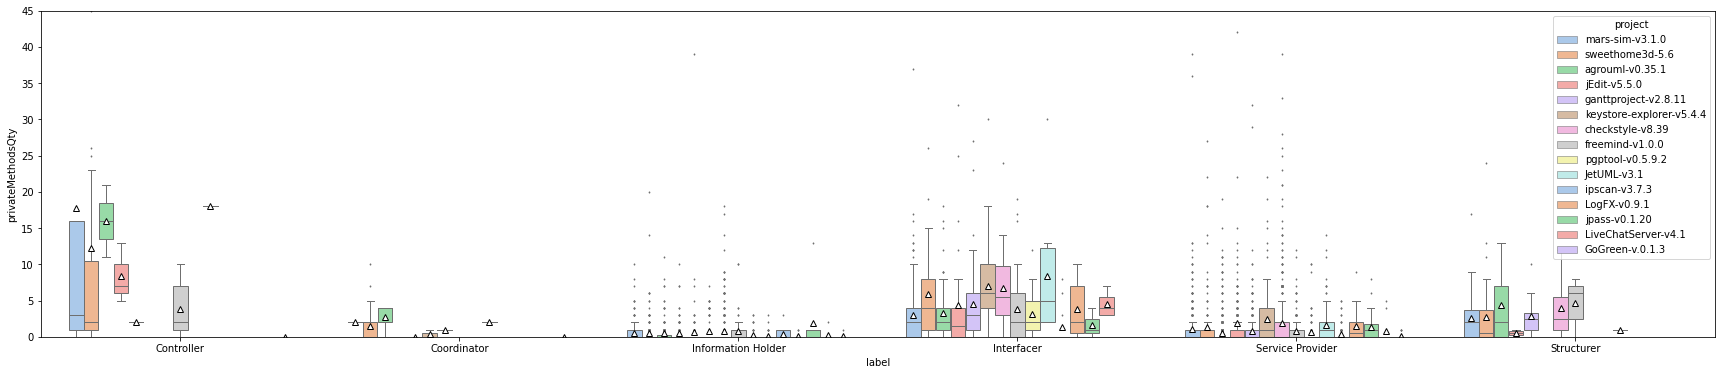

[abstractMethodsQty]


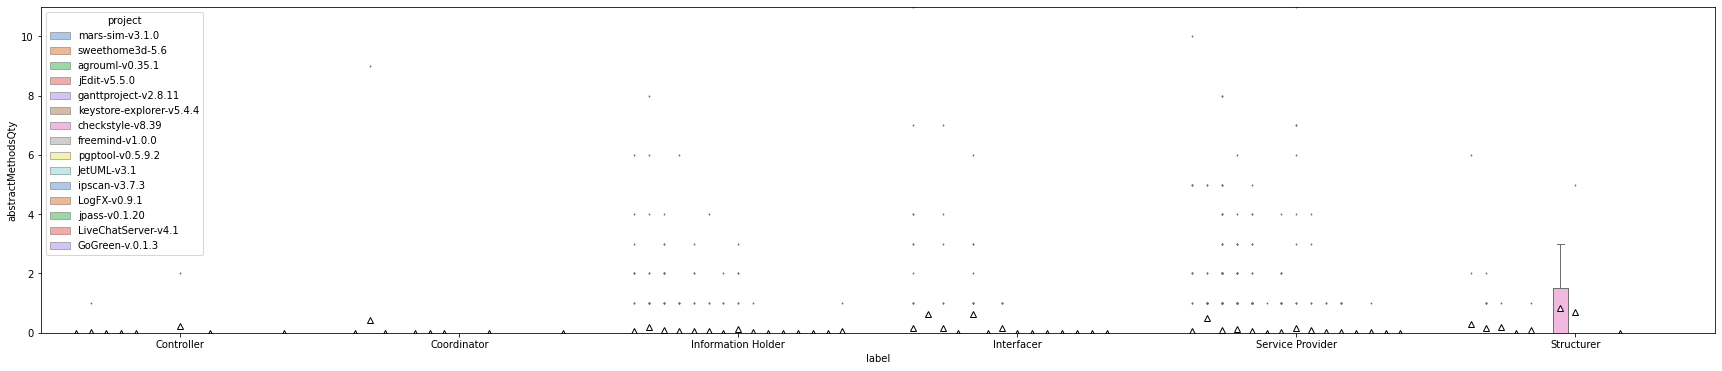

[finalMethodsQty]


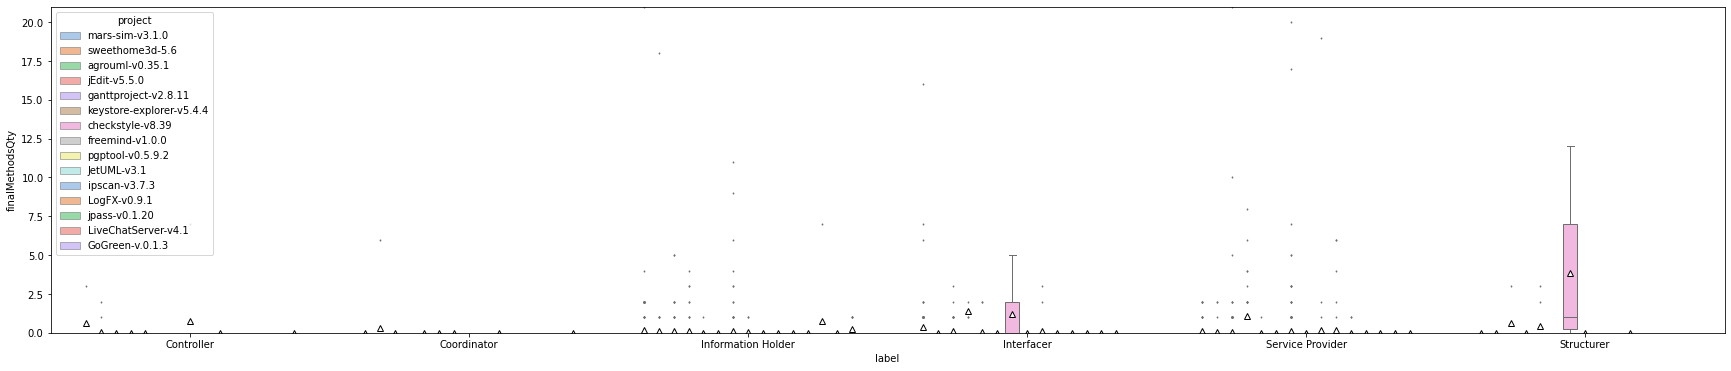

[totalFieldsQty]


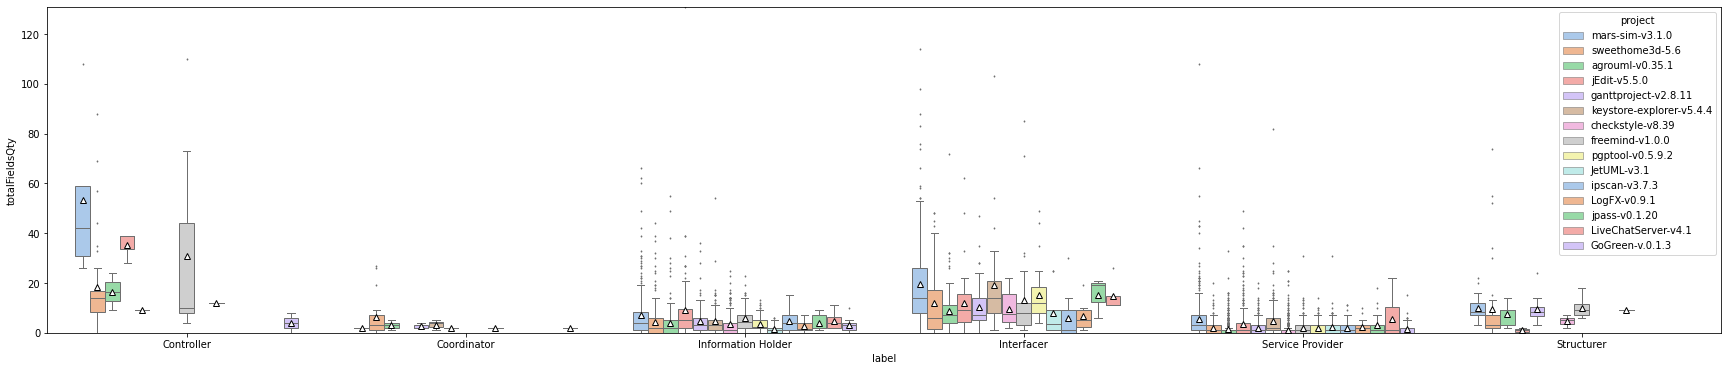

[publicFieldsQty]


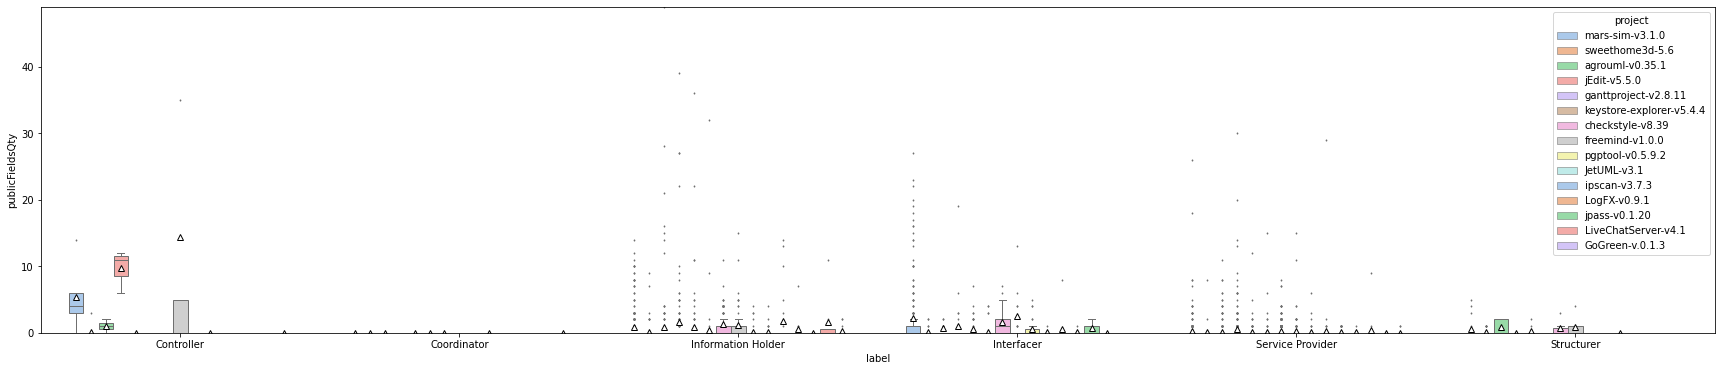

[privateFieldsQty]


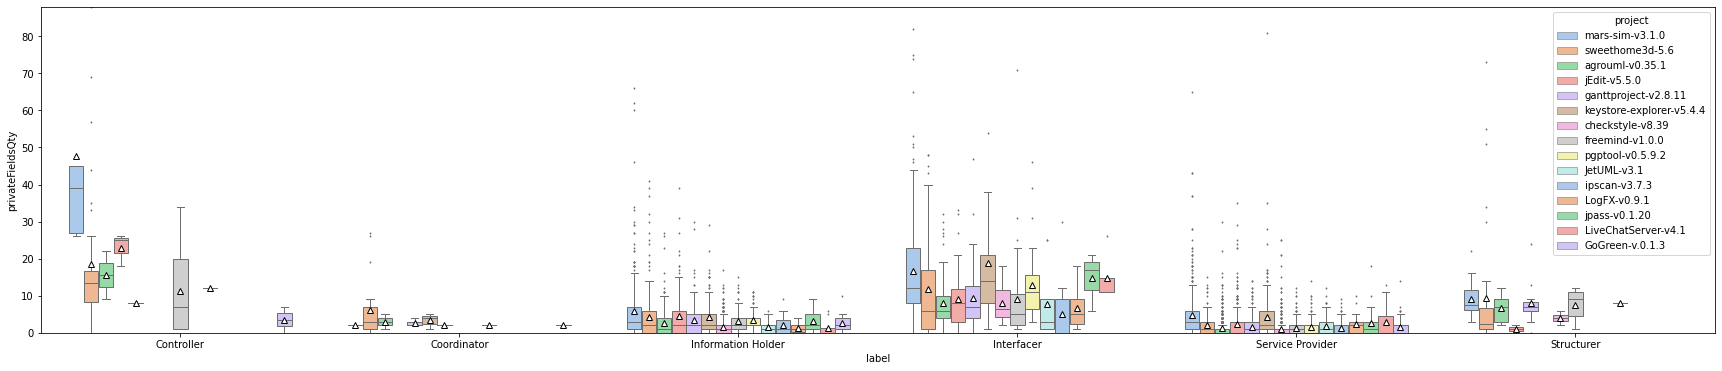

[finalFieldsQty]


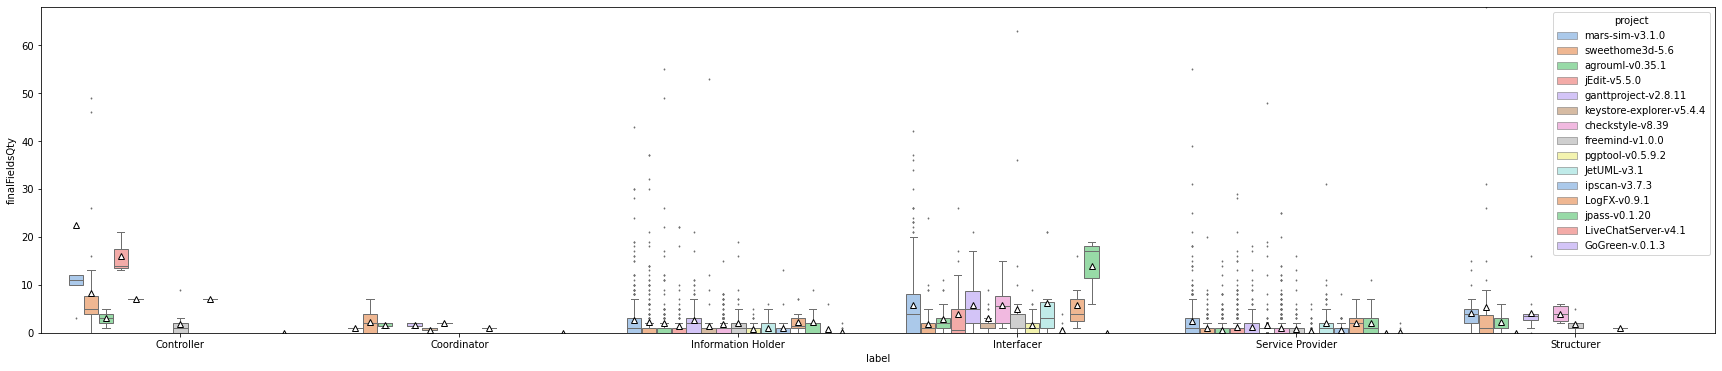

[nosi]
NOSI (Number of static invocations): Counts the number of invocations to static methods. It can only count the ones that can be resolved by the JDT.


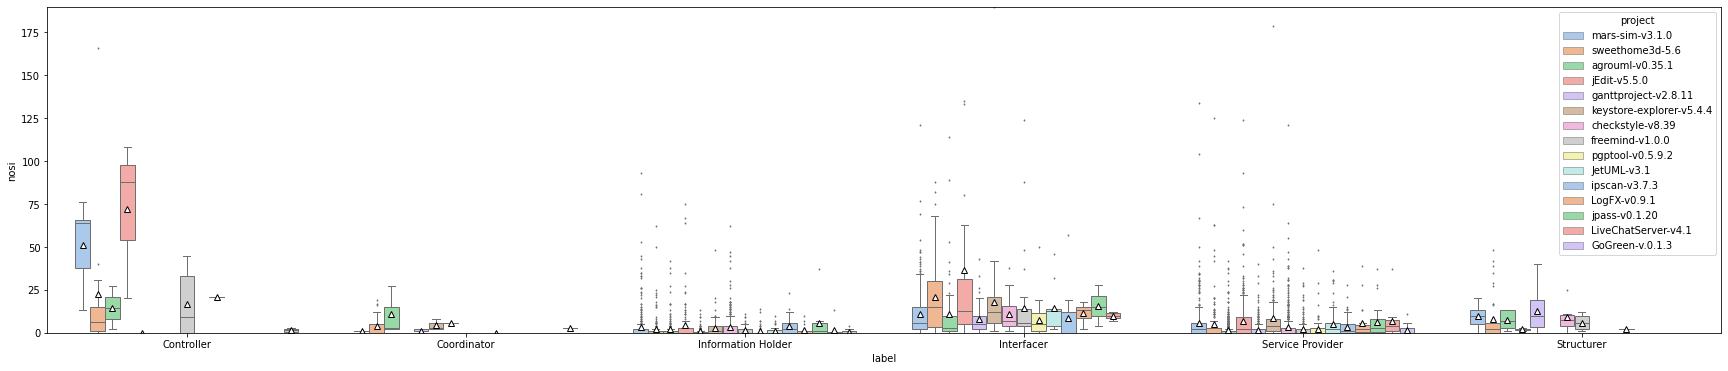

[loc]
LOC (Lines of code): It counts the lines of count, ignoring empty lines and comments (i.e., it's Source Lines of Code, or SLOC). The number of lines here might be a bit different from the original file, as we use JDT's internal representation of the source code to calculate it.


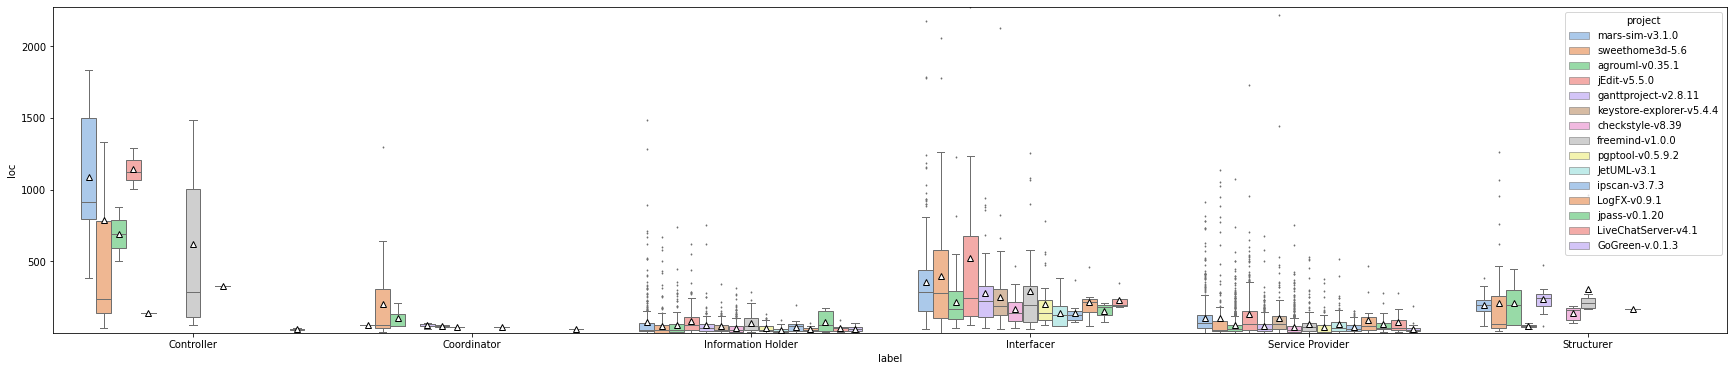

[returnQty]
Quantity of returns: The number of return instructions.


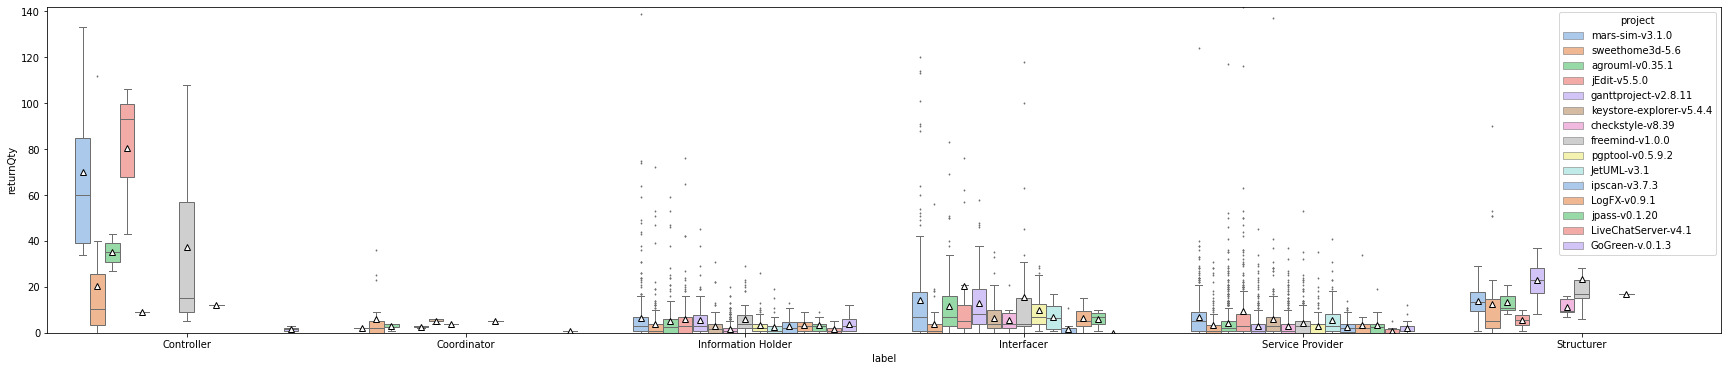

[loopQty]
Quantity of loops: The number of loops (i.e., for, while, do while, enhanced for).


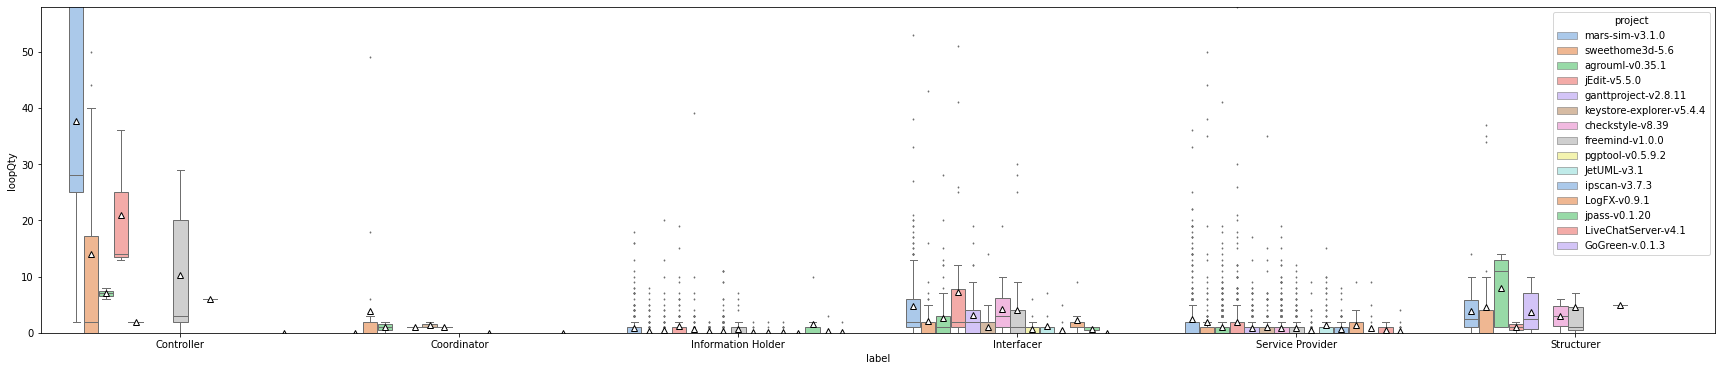

[comparisonsQty]
Quantity of comparisons: The number of comparisons (i.e., == and !=). Note: != is only available in 0.4.2+.


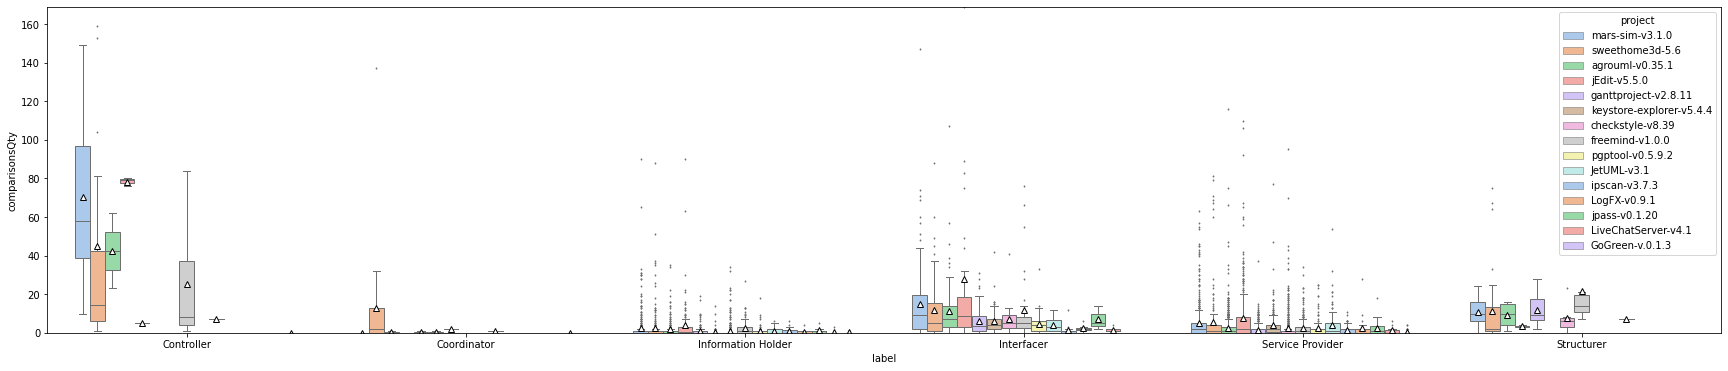

[tryCatchQty]
Quantity of try/catches: The number of try/catches


[parenthesizedExpsQty]
Quantity of parenthesized expressions: The number of expressions inside parenthesis.


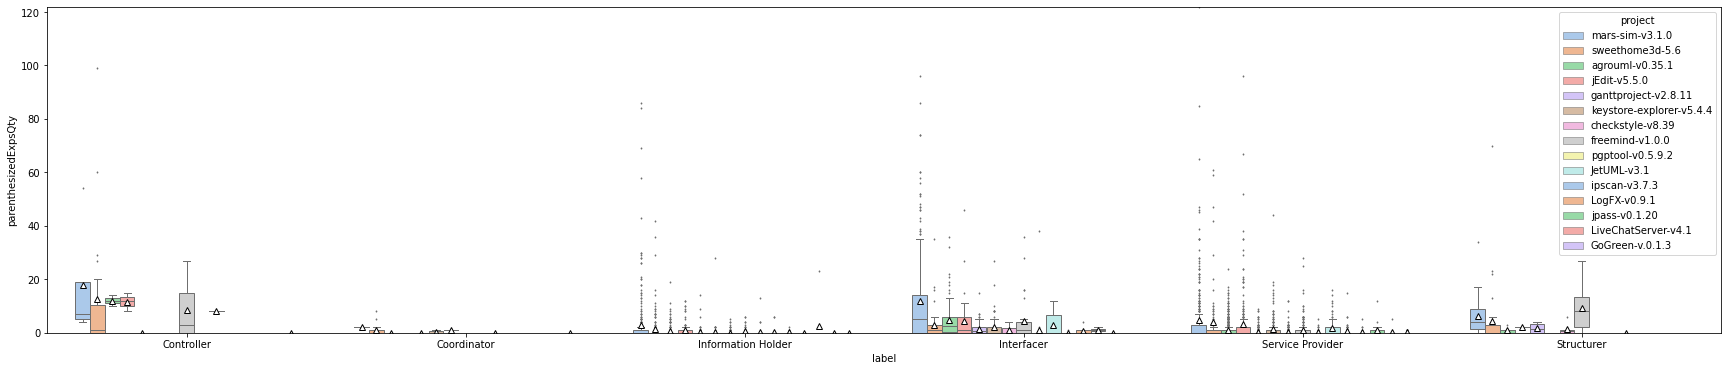

[stringLiteralsQty]
String literals: The number of string literals (e.g., "John Doe"). Repeated strings count as many times as they appear.


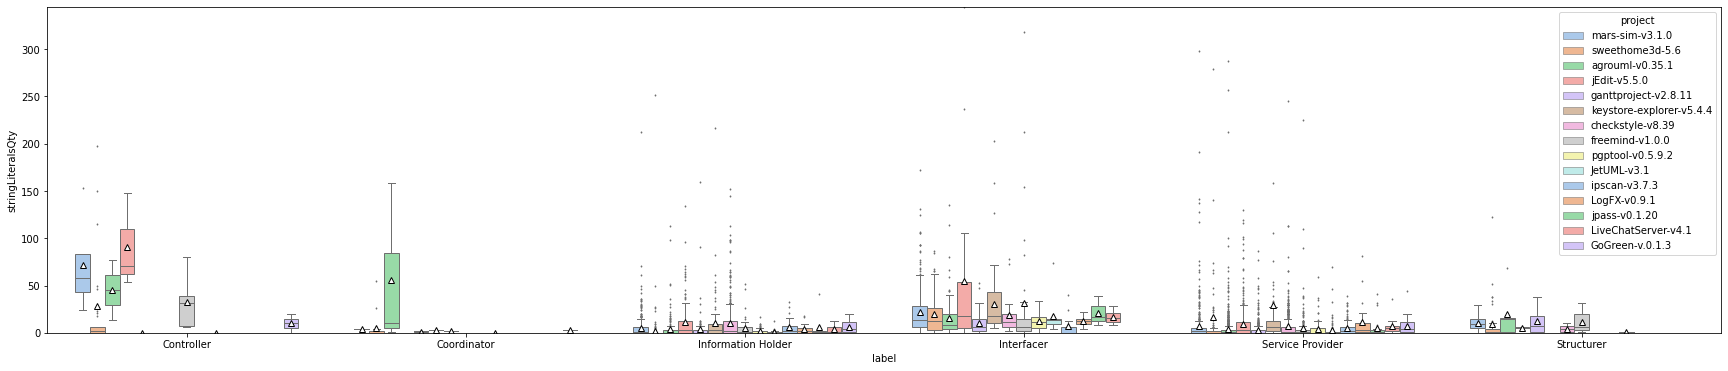

[numbersQty]
Quantity of Number: The number of numbers (i.e., int, long, double, float) literals.


[assignmentsQty]


[mathOperationsQty]
Quantity of Math Operations: The number of math operations (times, divide, remainder, plus, minus, left shit, right shift).


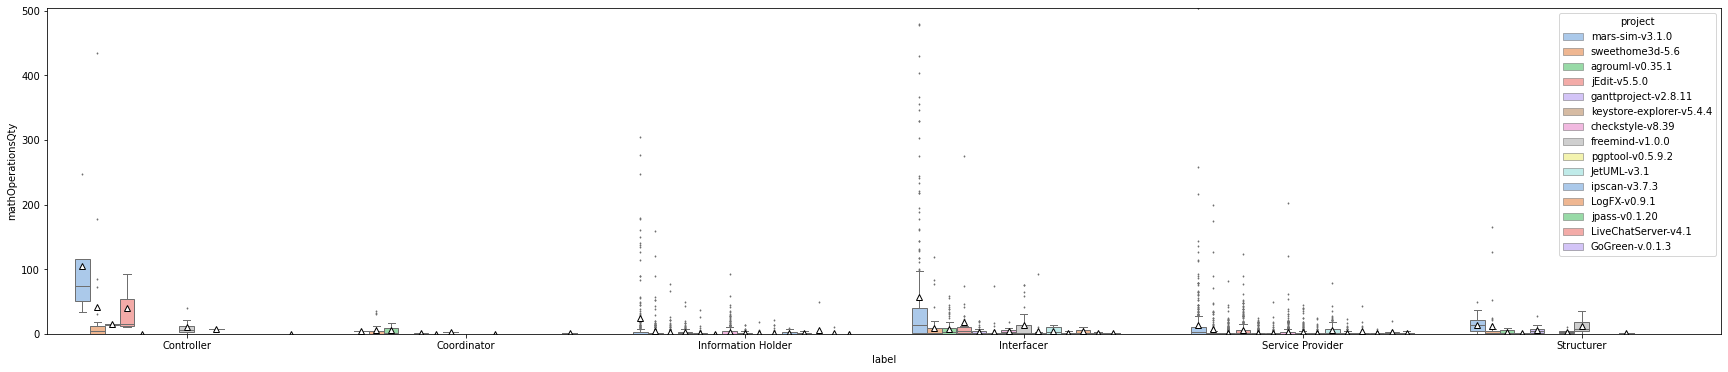

[variablesQty]
Quantity of Variables: Number of declared variables.


[maxNestedBlocksQty]
Max nested blocks: The highest number of blocks nested together.


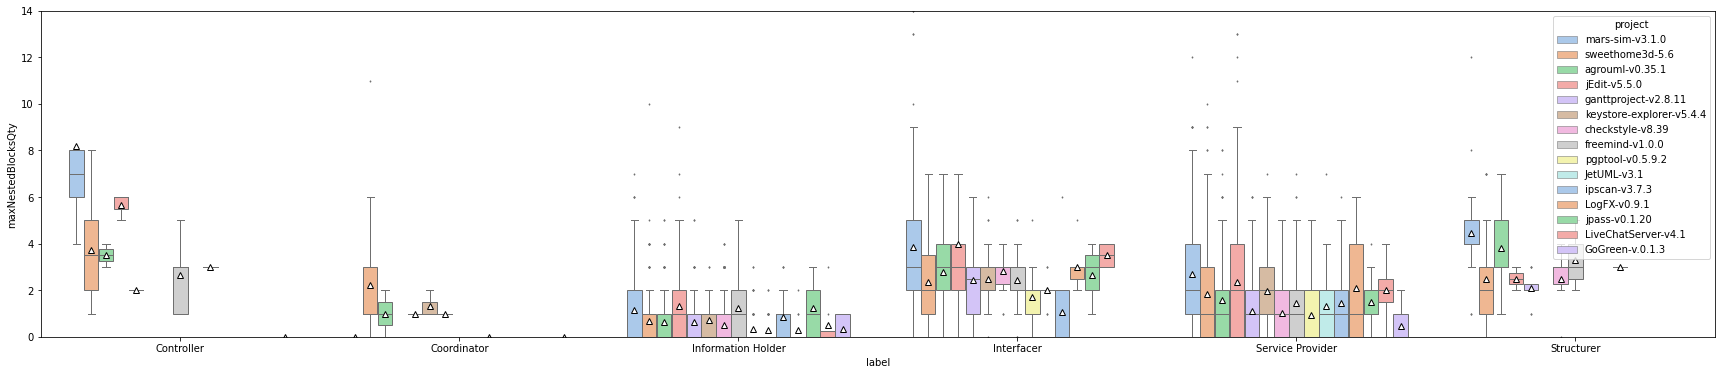

[anonymousClassesQty]
Quantity of Anonymous classes, inner classes, and lambda expressions: The name says it all. Note that whenever an anonymous class or an inner class is declared, it becomes an "entire new class", e.g., CK generates A.B and A.B$C, C being an inner class inside A.B. However, lambda expressions are not considered classes, and thus, are part of the class/method they are embedded into. A class or a method only has the number of inner classes that are declared at its level, e.g., an inner class that is declared inside a method M2, that is inside an anonymous class A, that is declared inside a method M, that finally is declared inside a class C, will not count in class C, but only in method M2 (first-level method it is embodied), and anonymous class A (first-level class it is embodied).


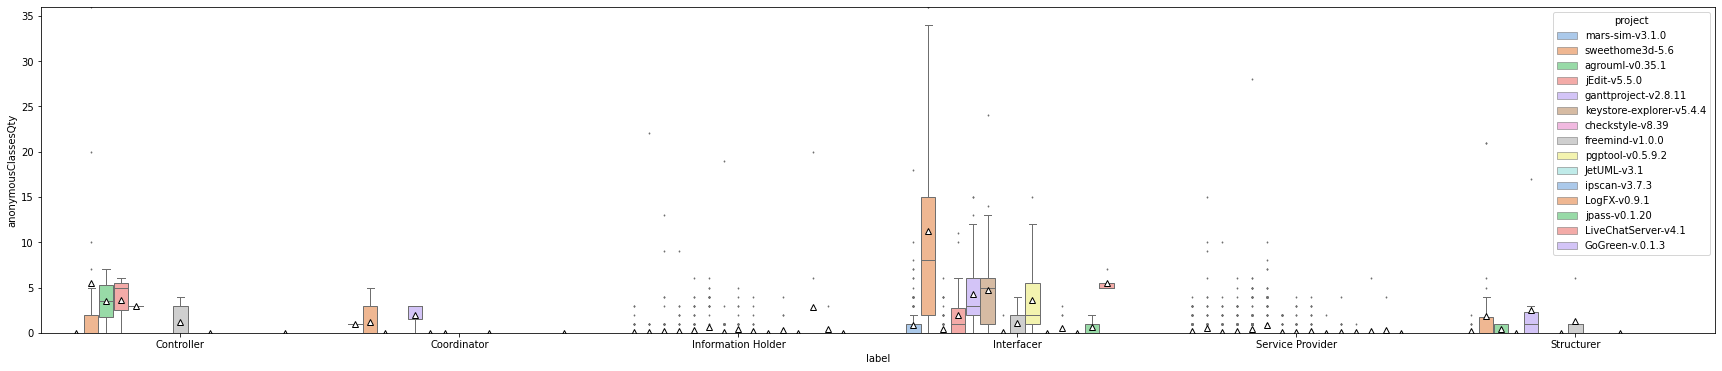

[innerClassesQty]


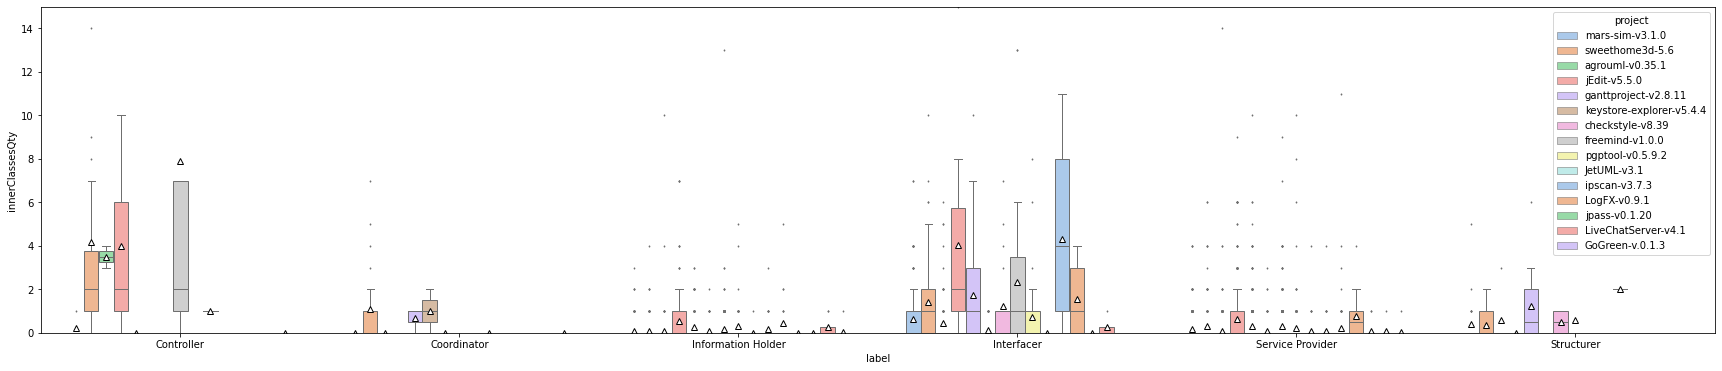

[lambdasQty]


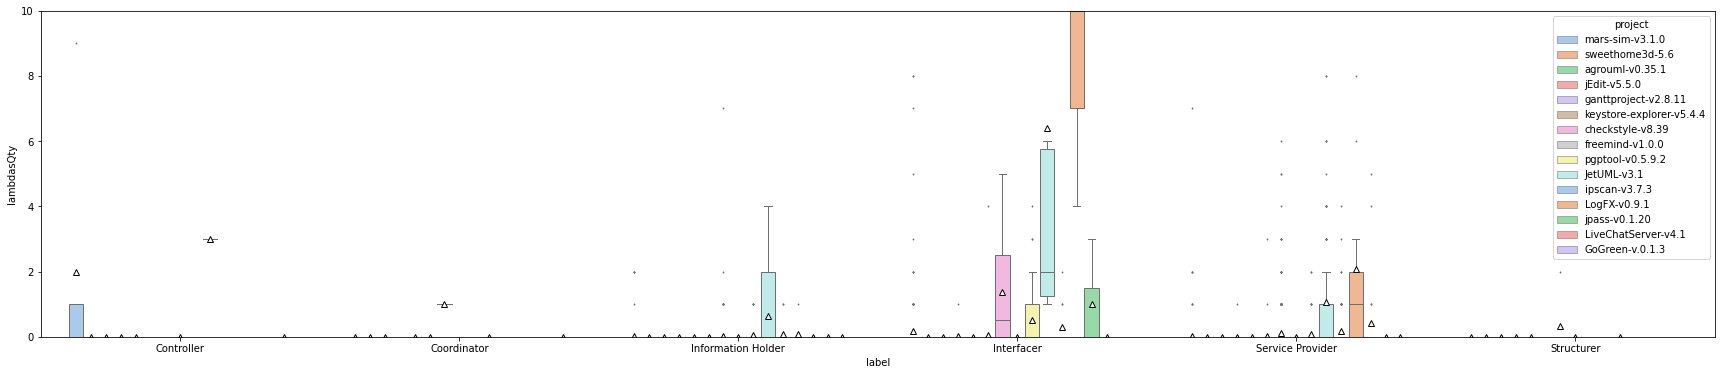

[uniqueWordsQty]
Number of unique words: Number of unique words in the source code. At method level, it only uses the method body as input. At class level, it uses the entire body of the class as metrics. The algorithm basically counts the number of words in a method/class, after removing Java keywords. Names are split based on camel case and underline (e.g., longName_likeThis becomes four words). See WordCounter class for details on the implementation.


[ratio_publicMethods]


[ratio_privateMethods]


[ratio_publicFields]


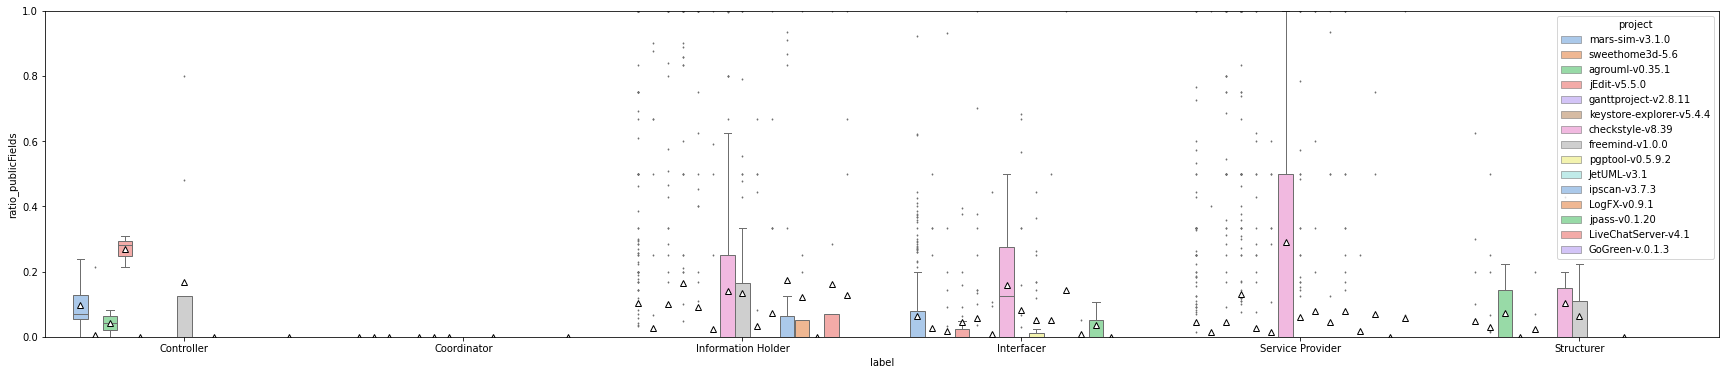

[ratio_privateFields]


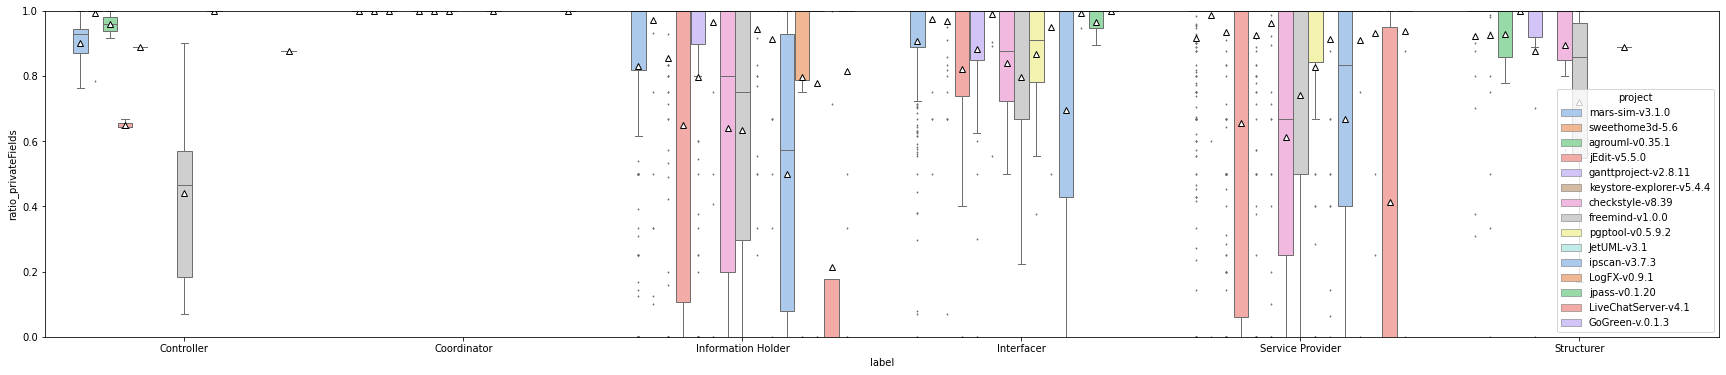

In [11]:
i = 0
for metric in metrics:
  plt.figure(i, figsize=(30,6))
  print(f"[{metric}]")
  if metric in metrics_def.keys():
    print(metrics_def[metric])
  g = sns.boxplot(x="label", y=metric,
      hue="project",
      hue_order=prj_order,
      palette="pastel", 
      order=rstr,
      linewidth=1, fliersize=1,
      showmeans=True,
      meanprops = {"markerfacecolor":"white", "markeredgecolor": "black"},
      data=alldf)
  mn = alldf[metric].min()
  mx = alldf.quantile(.999, interpolation="higher")[metric]
  g.set(ylim=(mn,mx))
  plt.show()
  i += 1